# **Tarea 1**

 GI_02 - Gonzalo Cruz Gómez

Para esta tarea vamos a trabajar con el dataset [healthcare-dataset-stroke-data](https://https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download). Con este dataset trataremos de resolver un problema de **clasificación**, en el cual nuestro target es si el paciente tiene o no un derrame cerebral (**stroke**). Primeramente realizaremos un **análisis descriptivo y exploratorio** de los datos, también un **preprocesamiento** de los mismos si fuera necesario. Después abordaremos nuestra tarea de clasificación mediante el uso de un **esquema logístico**, aplicando **regularización** y **métodos wrapper** de selección de características. Además, aplicaremos un **MLP**, explorando su condición como **"aproximador universal"** y resolviendo el problema con este enfoque. Por último compararemos resultados con los modelos de todos los apartados y elegiremos uno.

Importamos las librerías necesarias, así como nuestro dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold


warnings.filterwarnings('ignore')

In [4]:
stroke = pd.read_csv('GI_02.csv')
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
stroke.shape

(5110, 12)

## ***Sección I. Análisis descriptivo y exploratorio de los datos. Preprocesamiento***

Vamos a ver cuántos NaN tenemos en nuestro df

In [6]:
print(stroke.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Podemos ver que solamente tenemos NaN en el bmi, tenemos que ver qué hacemos con estas filas, ya que se trata de unas cuantas observaciones.

Vamos a hacer primeramente el split de train-test-validate (estratificado), además de eliminar los id del df

In [7]:
stroke.drop('id', axis=1, inplace=True)

In [8]:
X_train, x_temp, y_train, y_temp = train_test_split(stroke.drop('stroke', axis=1), stroke['stroke'], test_size=0.4, random_state=123, stratify=stroke['stroke'])
X_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

Vamos a lidiar con los NaN de bm. Para ello voy a imputar estas observaciones con el valor del bmi obtenido de hacer el knn con los vecinos mas cercanos

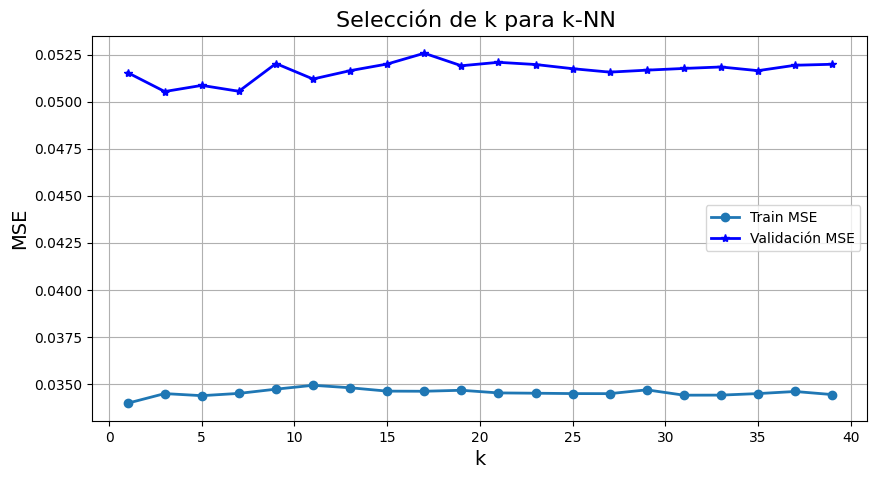

In [9]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])
k_grid = np.array(range(1, 41,2))
param_grid = {'imputer__n_neighbors': k_grid}

grid_knn_imputer = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

grid_knn_imputer.fit(X_train[numeric_features], y_train)

results = grid_knn_imputer.cv_results_
k_grid_results = results['param_imputer__n_neighbors'].data

mse_train = -1 * np.array(results['mean_train_score'])
mse_val = -1 * np.array(results['mean_test_score'])

plt.figure(figsize=(10, 5))
plt.plot(k_grid_results, mse_train, '-o', label="Train MSE", linewidth=2)
plt.plot(k_grid_results, mse_val, '-*b', label="Validación MSE", linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title('Selección de k para k-NN ', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()



Vemos como en validación, el valor es bastante estable pero para valores grandes empieza a variar un poco más. Vamos a elegir una k = 5 ya que es un valor en el que el MSE comienza a estabilizarse y no es demasiado grande. Para ello voy a utilizar KNNImputer que rellena los valores faltantes sin modificar los ya existentes.

In [10]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train[numeric_features])

X_train[numeric_features] = imputer.transform(X_train[numeric_features])
X_val[numeric_features] = imputer.transform(X_val[numeric_features])
x_test[numeric_features] = imputer.transform(x_test[numeric_features])

print(f"NaNs en X_train['bmi']: {X_train['bmi'].isnull().sum()}")
print(f"NaNs en X_val['bmi']: {X_val['bmi'].isnull().sum()}")
print(f"NaNs en X_test['bmi']: {x_test['bmi'].isnull().sum()}")

NaNs en X_train['bmi']: 0
NaNs en X_val['bmi']: 0
NaNs en X_test['bmi']: 0


Ahora ya no tenemos ningun NaN en el dataset. Vamos a ver cómo son nuestras variables

**Vamos a ver qué tipo de variables tenemos:**


In [11]:
X_train.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64
smoking_status,object


En cuanto al tipo de variables, nos encontramos con variables de tipo int: hypertension, heart_disease y stroke. Después de tipo float tenemos: age, avg_glucose_level y bmi. Por últipo tenemos variables categóricas, que tienen el tipo object: gender, ever_married, work_type, residence_type y smoking_status

**A continuación vamos a hacer un análisis descriptivo de las variables**

In [12]:
X_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000
mean,42.752211,0.100783,0.053816,106.330192,28.945871
std,22.679769,0.301090,0.225691,45.882474,7.822690
min,0.080000,0.000000,0.000000,55.120000,12.300000
25%,25.000000,0.000000,0.000000,77.492500,23.500000
50%,44.000000,0.000000,0.000000,92.120000,28.200000
75%,60.000000,0.000000,0.000000,113.615000,33.100000
max,82.000000,1.000000,1.000000,271.740000,97.600000


In [13]:
X_train.shape

(3066, 10)

Vamos a ver cuántos valores únicos tiene cada variable. El objetivo de esto es ver si hay algún numero de valores extraño para una variable

In [14]:
X_train.nunique()

,0
gender,3
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,2623
bmi,476
smoking_status,4


Podemos ver que tenemos 3 valores únicos en gender, esto podría significar que tenemos una categoría de género no binario o bien que se trata de una categoría de valor faltante.

Vamos a ver qué ocurre con la variable **gender**

In [15]:
X_train['gender'].value_counts()

,count
gender,
Female,1800
Male,1265
Other,1


Vemos que tenemos una categoría llamada other en el género, vamos a ver cómo es dicha observación para entender cómo debemos lidiar con ella.

In [16]:
X_train[X_train['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked


Podemos ver que la observación es completamente normal, no tiene nada raro, por lo que debemos mantener la observación. En este caso obtaremos por ver la categoría de género de los vecinos más cercanos y la asignaremos a dicha categoría. Voy a utilizar los 5 vecinos más cercanos para hacerlo.

In [17]:

numeric_features = ['age','avg_glucose_level','bmi']

idx_to_impute = X_train[X_train['gender'] == 'Other'].index
train_data = X_train[X_train['gender'] != 'Other']
X_knn_train = train_data[numeric_features]
y_knn_train = train_data['gender'].map({'Male': 0, 'Female': 1})
X_to_predict = X_train.loc[idx_to_impute, numeric_features]

knn_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_knn_train, y_knn_train)
predicted_encoded_value = knn_pipeline.predict(X_to_predict)
valor_predicho = predicted_encoded_value[0]

map_inverso = {0: 'Male', 1: 'Female'}
predicted_gender = map_inverso[valor_predicho]

print(f"El género predicho para la fila 'Other' es: {predicted_gender}")
X_train.loc[idx_to_impute, 'gender'] = predicted_gender

El género predicho para la fila 'Other' es: Female


Una vez hecho esto, vamos a analizar la variable age para ver qué ocurre.

In [18]:
X_train['age'].value_counts()

,count
age,
78.00,62
57.00,57
61.00,53
31.00,53
53.00,53
...,...
0.48,2
1.16,2
0.08,1


Vemos que, efectivamente, tenemos decimales en las edades. Esto no es un problema, por lo que las dejaremos así, puede que para algún análisis hagamos categorías o agrupemos a todos aquellos con igual año por año para que dicho análisis sea más sencillo


### Análisis univariante


Vamos a analizar nuestras variables por separado para saber más sobre ellas.


Primeramente vamos a ver la distribución de nuestras variables.


In [19]:
# convertimos el tipo de nuestras variables categóricas para hacer bien los diagramas
X_train['gender'] = X_train['gender'].astype('category')
X_train['ever_married'] = X_train['ever_married'].astype('category')
X_train['work_type'] = X_train['work_type'].astype('category')
X_train['Residence_type'] = X_train['Residence_type'].astype('category')
X_train['smoking_status'] = X_train['smoking_status'].astype('category')
X_train['heart_disease'] = X_train['heart_disease'].astype('category')
X_train['hypertension'] = X_train['hypertension'].astype('category')
y_train = y_train.astype('category')

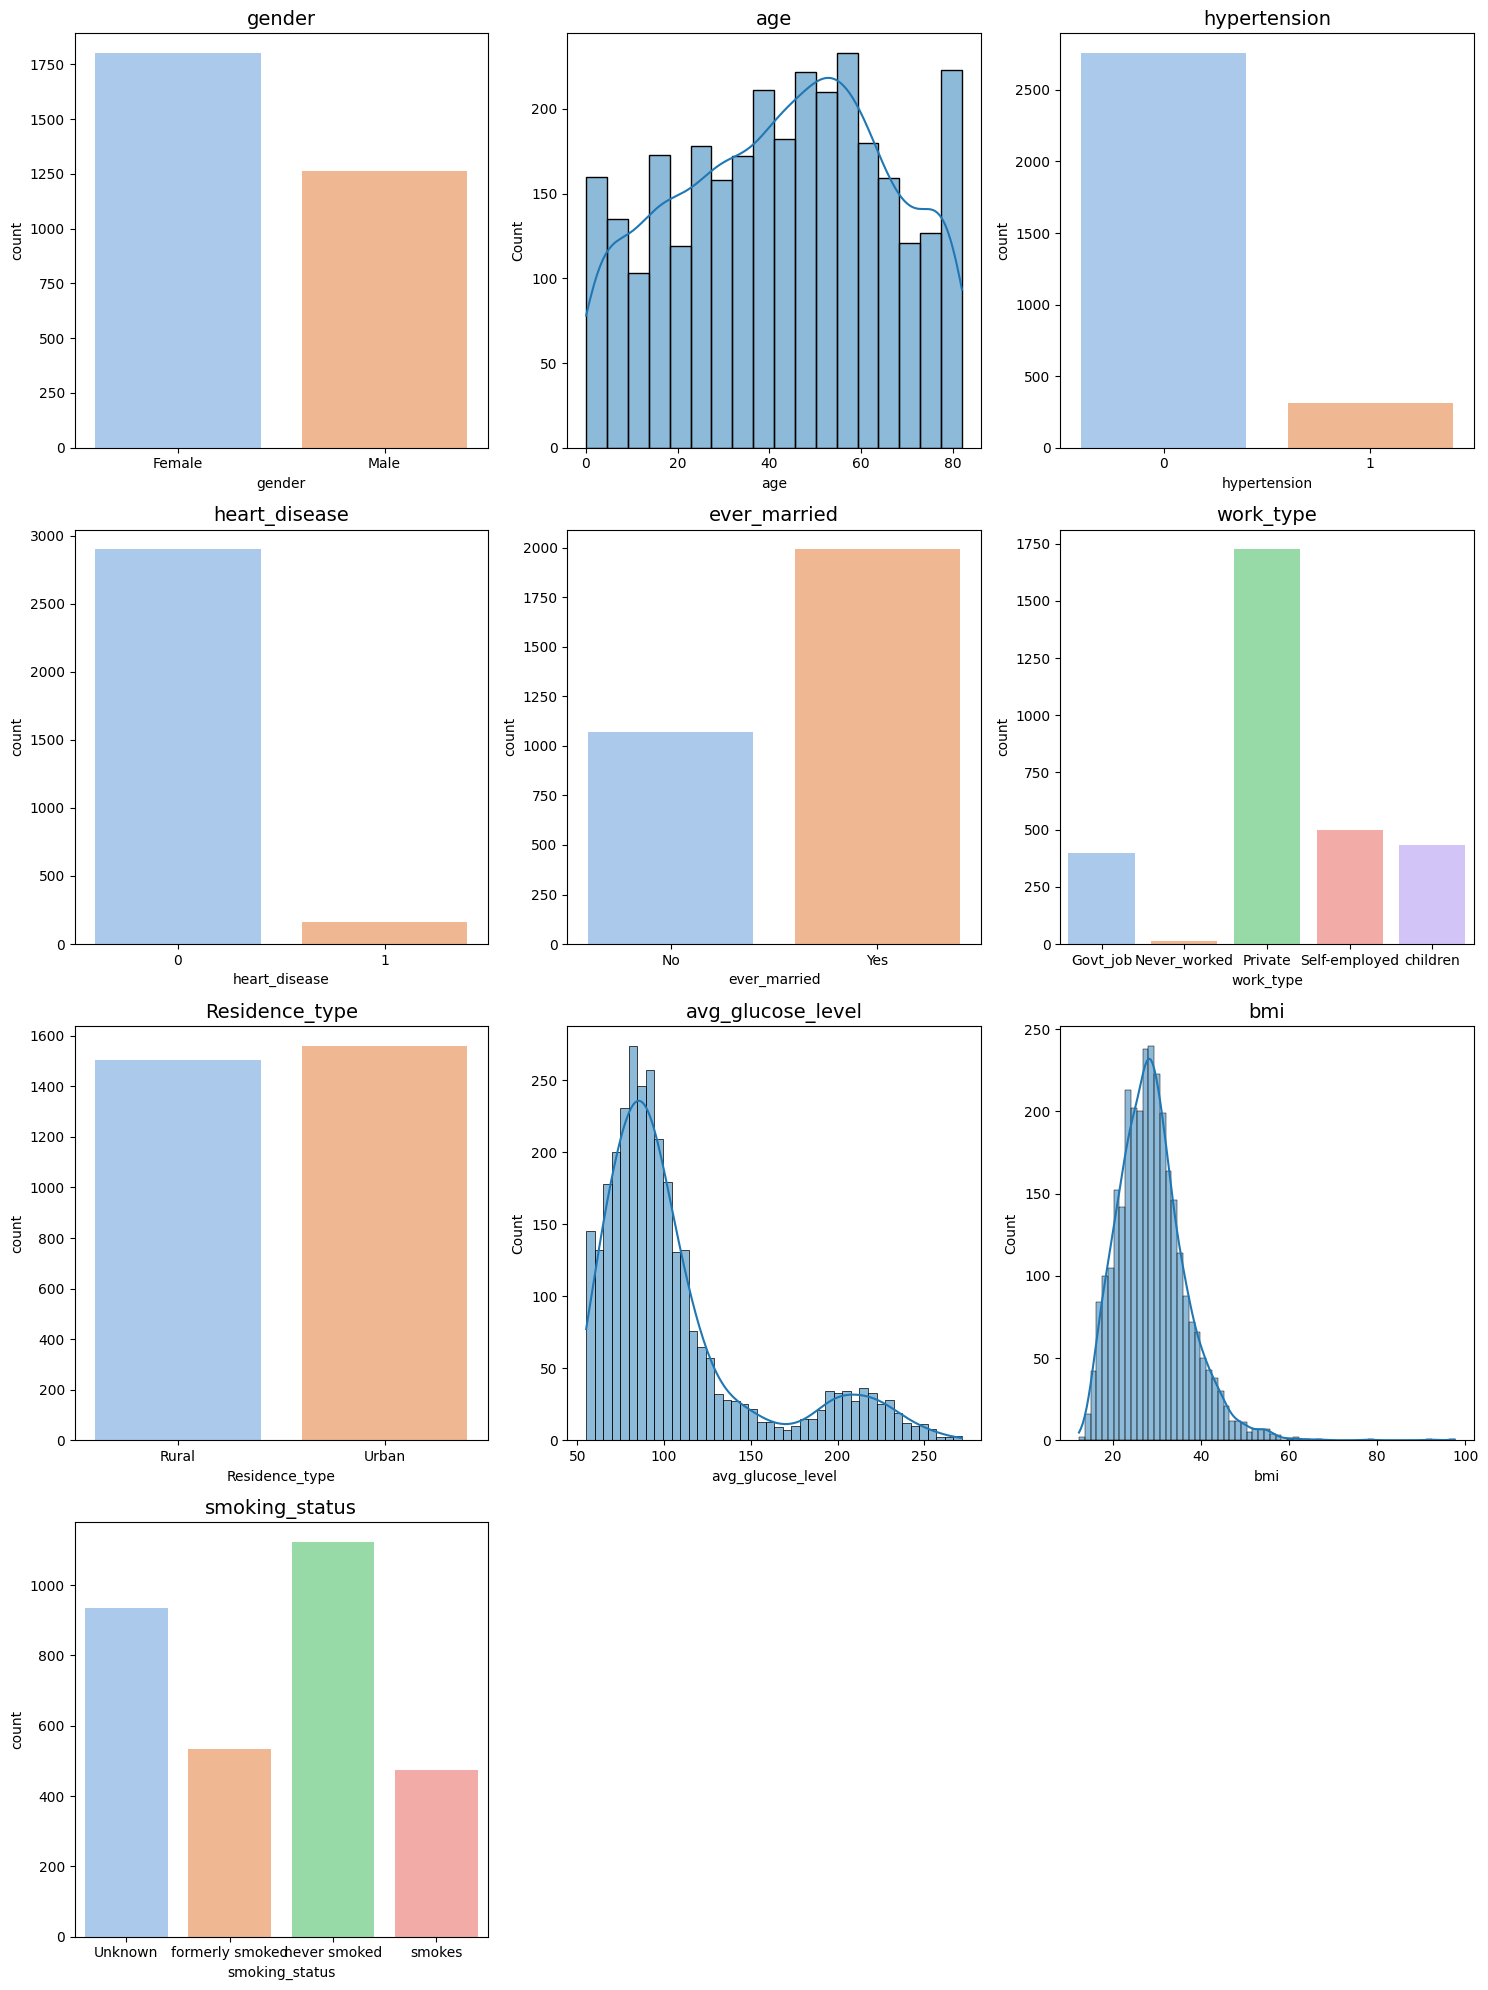

In [20]:
columnas = X_train.columns
columnas_plot = list(columnas)
if 'id' in columnas_plot:
    columnas_plot.remove('id')

num_columnas = len(columnas_plot)
grid_cols = 3
grid_rows = math.ceil(num_columnas / grid_cols)

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 5 * grid_rows))
axes = axes.flatten()

for i, column in enumerate(columnas_plot):
    ax = axes[i]
    if pd.api.types.is_numeric_dtype(X_train[column]):
        sns.histplot(X_train[column], kde=True, ax=ax)
        ax.set_title(f'{column}', fontsize=14)
    else:
        sns.countplot(data=X_train, x=column, ax=ax, palette='pastel')
        ax.set_title(f'{column}', fontsize=14)

for i in range(num_columnas, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Podemos ver cómo la variable age tiene más valores en edades a partir de los 50 y un gran pico en las personas mayores de 80 años, esto podría significar que aquellos más mayores tienen más tendencia a tener problemas cardiovasculares, pero tendremos que comprobarlo más adelante cuando hagamos el análisis multivariante.

También vemos que en algunas de nuestras variables categóricas tenemos un gran desvalance de clases como en heart disease, hypertension o ever_married. Esto podría deberse a que es más común no tener ninguna de estas condiciones frente a sí tenerla.

De las variables categóricas también debemos destacar la variable smoking_status, de la cual tenemos valores desconocidos.

Por ultimo, de nuestras variables continuas, vemos como el nivel de glucosa tiene un gran pico en la zona saludable (alrededor de unos 85-95) y otro segundo pico, esta vez mucho más pequeño, en la zona de los 200, esta zona es la zona de la hiperglucemia.

En cuanto a el bmi, vemos como tiene una cola muy larga hacia la derecha, pudiendose tratar de valores atípicos o casos de obesidad muy extrema.

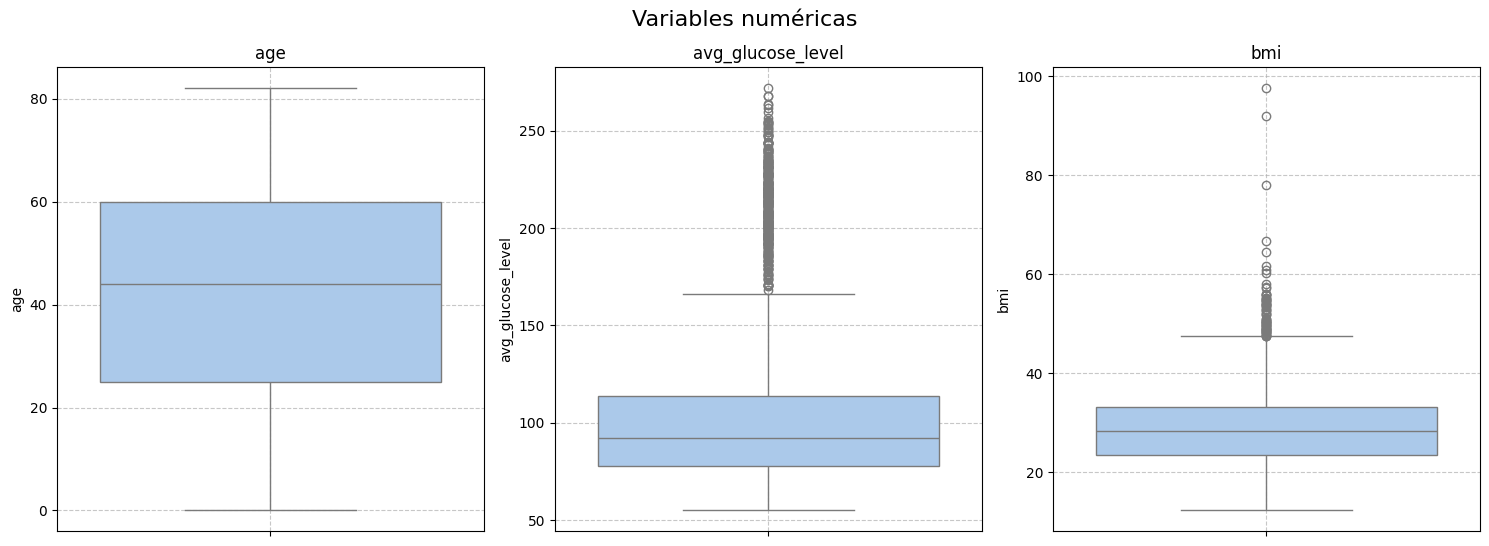

In [21]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=X_train[feature], palette='pastel')
    plt.title(f'{feature}', fontsize=12)
    plt.ylabel(feature)
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Variables numéricas', y=1.02, fontsize=16)
plt.show()

Vemos como efectivamente tenemos outliers en el bmi y en glucose_level. Podemos extraer la misma conclusión que con los histogramas, tenemos colas muy largas. Para lidiar con estos outliers, tendremos que transformar dichas características para que no tengan mucho peso en los modelos estos outliers y nos fastidien el análisis.

Vamos a ver cómo es nuestra variable objetivo

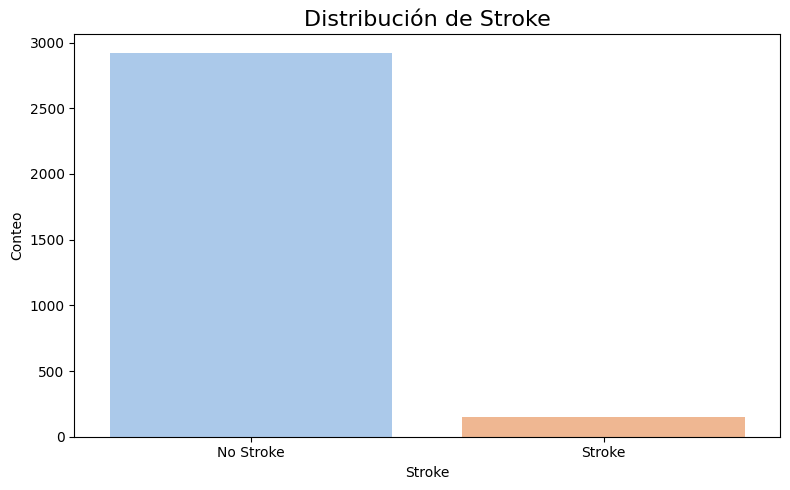

In [22]:
counts = y_train.value_counts()
counts.index = counts.index.map({0: 'No Stroke', 1: 'Stroke'})
counts_df = counts.reset_index()
counts_df.columns = ['Stroke', 'Conteo']

plt.figure(figsize=(8, 5))
sns.barplot(data=counts_df, x='Stroke', y='Conteo', palette='pastel')
plt.title('Distribución de Stroke', fontsize=16)
plt.tight_layout()


Podemos observar como tenemos un claro desbalanceo de clase, tenemos muchas más observaciones de gente sin strokes que con strokes.

### Análisis multivariante


A continuación vamos a hacer un análisis multivariante de nuestro dataset. Para ello primeramente vamos a ver la correlación de nuestras variables y luego las compararemos con nuestro target.

Vamos a empezar con un análisis de la correlación de nuestras variables numéricas


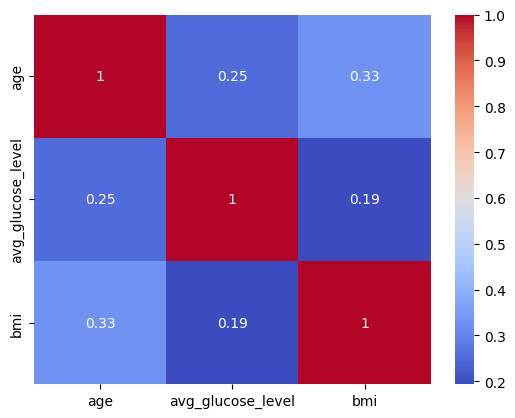

In [23]:
df_corr = X_train[numeric_features]
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Podemos ver cómo no tenemos ninguna correlación fuerte. Esto es bueno para nuestros modelos ya que no va a existir multicolinealidad (por lo que no vamos a tener que hacer selección de características a priori) y todas van a aportar información a nuestra predicción

A continuación vamos a representar las diferentes características entre si para ver si existe algún tipo de relación

<Figure size 1200x1200 with 0 Axes>

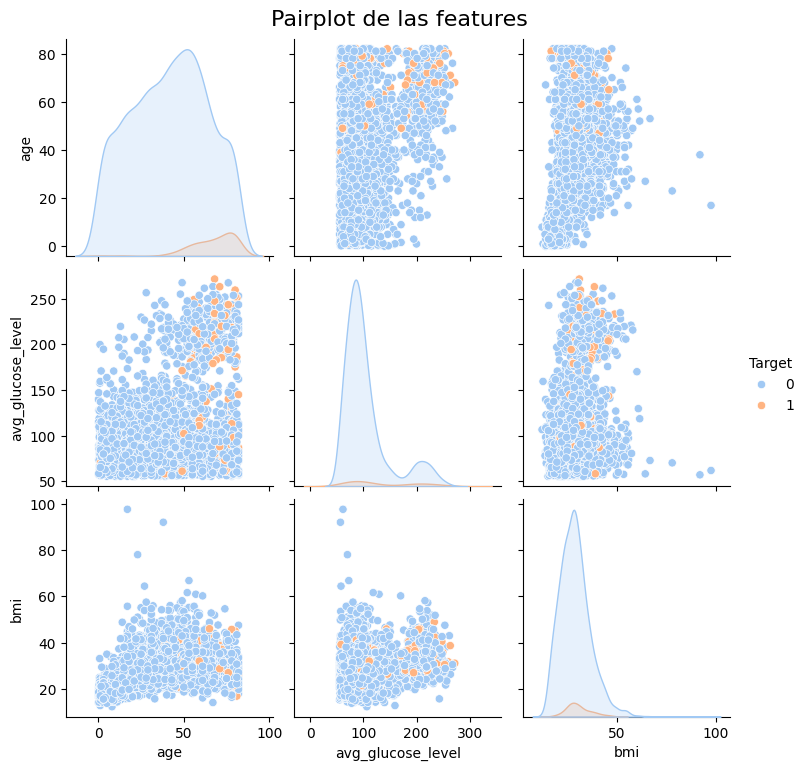

In [24]:
y_train.name = 'Target'
df_train_combined = pd.concat([X_train, y_train], axis=1)
plt.figure(figsize=(12, 12))

sns.pairplot(
    data=df_train_combined,
    hue='Target',
    diag_kind='kde',
    palette='pastel'
)

plt.suptitle('Pairplot de las features', y=1.02, fontsize=16)
plt.show()

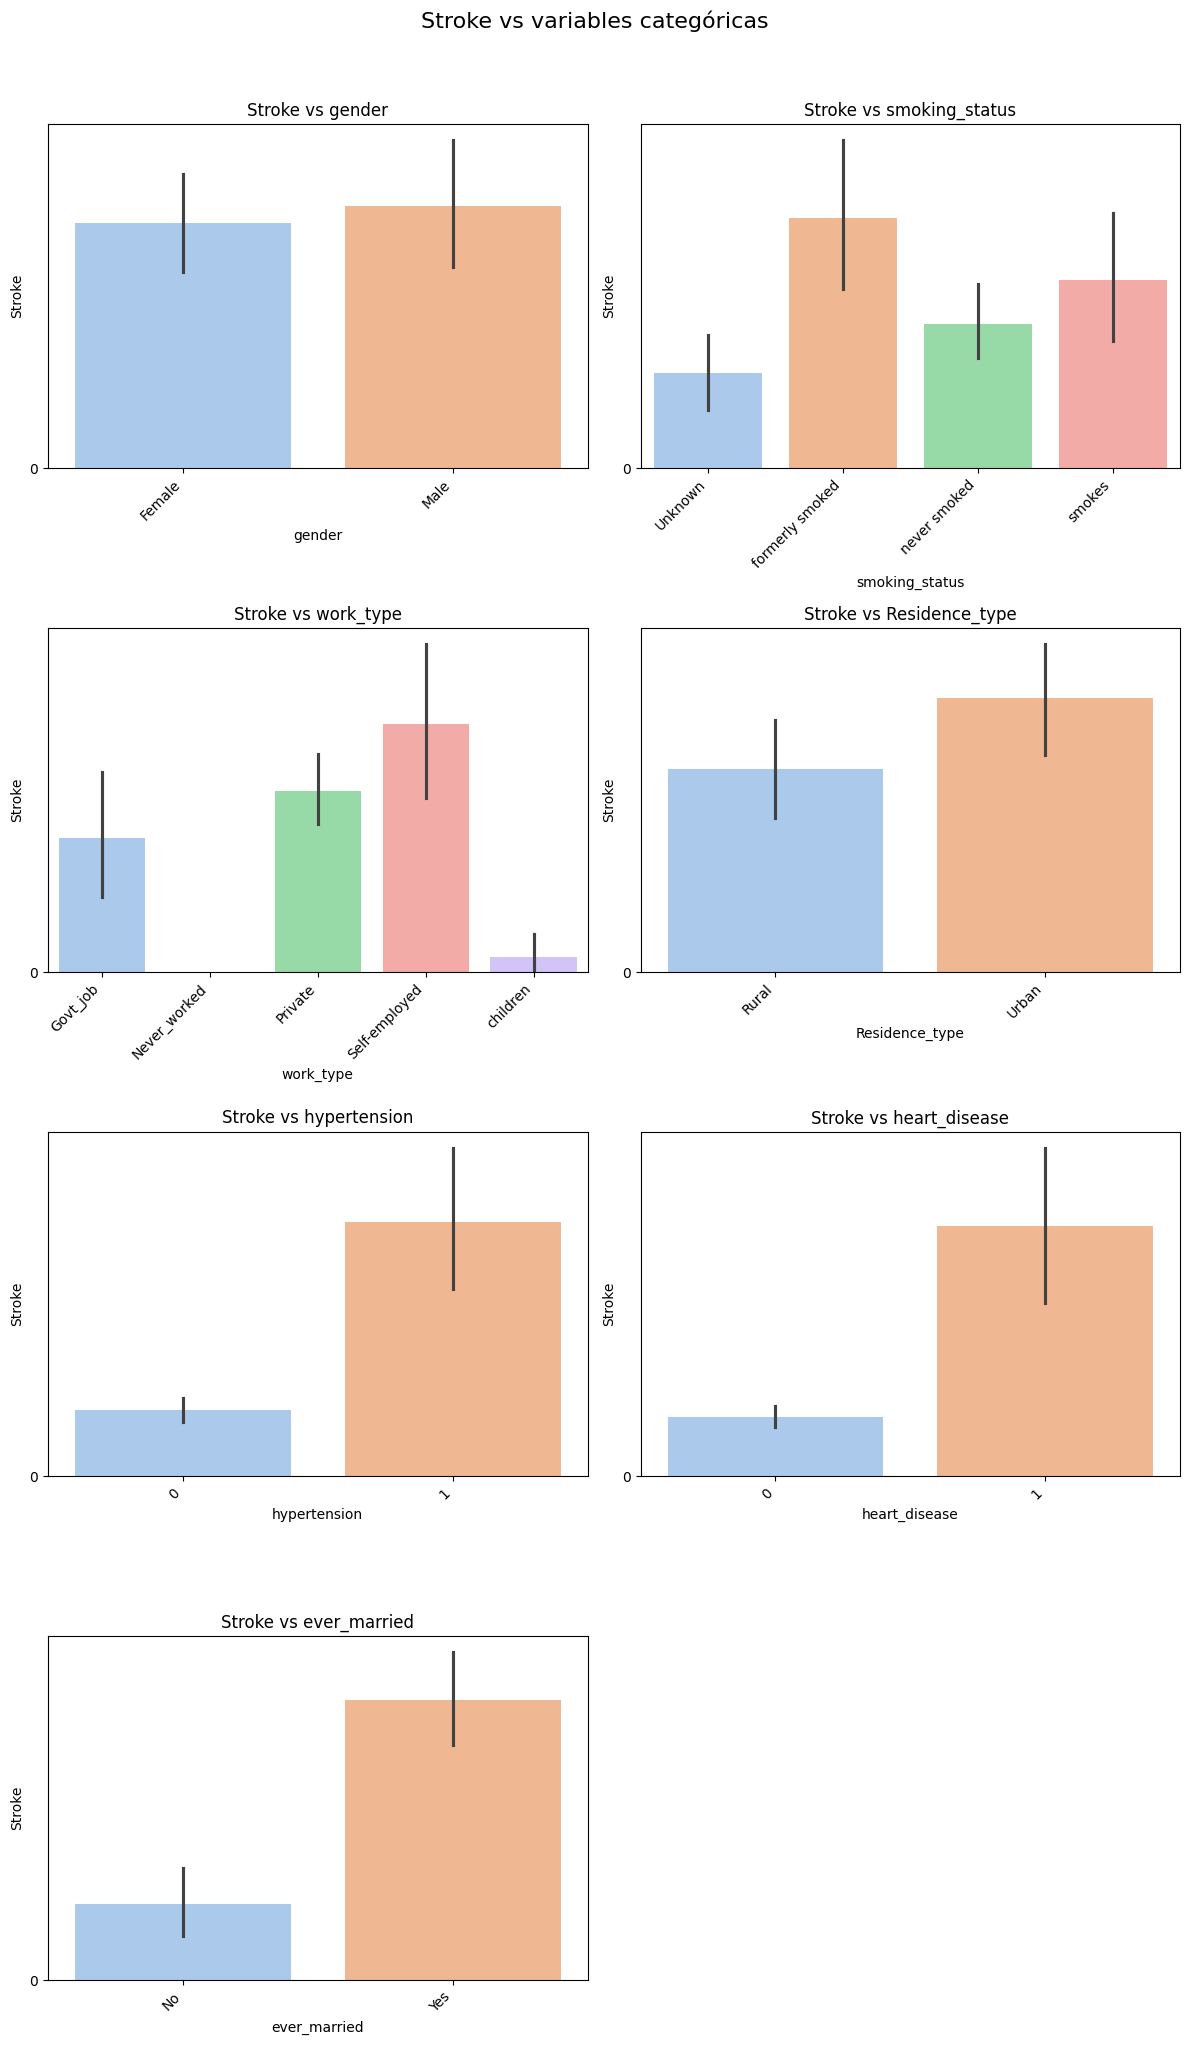

In [25]:
y_train.name = 'stroke'
categorical_features = ['gender', 'smoking_status', 'work_type', 'Residence_type', 'hypertension', 'heart_disease', 'ever_married']
df_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_combined['stroke'] = df_combined['stroke'].astype(str)
df_combined[categorical_features] = df_combined[categorical_features].astype('category')

num_features = len(categorical_features)
n_cols = 2
n_rows = (num_features + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))
plt.suptitle('Stroke vs variables categóricas', y=1.02, fontsize=16)

for i, feature in enumerate(categorical_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(
        x=feature,
        y='stroke',
        data=df_combined,
        palette='pastel',
    )
    plt.gca().invert_yaxis()
    plt.ylabel('Stroke')
    plt.xlabel(feature)
    plt.title(f'Stroke vs {feature}', fontsize=12)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Vamos a realizar test chi cuadrado para ver si estas diferencias son significativas entre las categorías.

In [26]:
def test_chi2(df, feature, target='stroke'):
    tabla_contingencia = pd.crosstab(df[feature], df[target])
    chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia)
    alpha = 0.05
    is_significant = 'Sí (p < 0.05)' if p_value < alpha else 'No (p >= 0.05)'
    return {
        'Chi2': chi2,
        'P-Valor': p_value,
        'Significativo': is_significant
    }
categorical_features = ['gender', 'smoking_status', 'work_type', 'Residence_type', 'hypertension', 'heart_disease', 'ever_married']
df_combined['stroke'] = df_combined['stroke'].astype(int)

results = {}
for feature in categorical_features:
    results[feature] = test_chi2(df_combined, feature)

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Feature'})

print(results_df.to_markdown(index=False, floatfmt=".4f"))

| Feature        |    Chi2 |   P-Valor | Significativo   |
|:---------------|--------:|----------:|:----------------|
| gender         |  0.1193 |    0.7298 | No (p >= 0.05)  |
| smoking_status | 18.7816 |    0.0003 | Sí (p < 0.05)   |
| work_type      | 27.8640 |    0.0000 | Sí (p < 0.05)   |
| Residence_type |  3.1951 |    0.0739 | No (p >= 0.05)  |
| hypertension   | 67.6632 |    0.0000 | Sí (p < 0.05)   |
| heart_disease  | 58.1141 |    0.0000 | Sí (p < 0.05)   |
| ever_married   | 33.0464 |    0.0000 | Sí (p < 0.05)   |


Como vemos, en género no tenemos una diferencia significativa, no hay evidencia de que el género determine si una persona va a tener o no un stroke. Ocurre lo mismo con el tipo de residencia, no hay diferencia estadísticamente significativa entre entornos urbanos y rurales.

En cambio, el smoking_status si que importa. Para ver estas diferencias debemos irnos al plot anterior, donde podemos ver que tanto aquellos que fumaban anteriormente como aquellos que fuman actualmente presentan un mayor número de casos de stroke que aquellos que no lo hacen o aquellos de los cuales se desconoce esta información. Esto tiene sentido ya que muchos estudios asocian el fumar con un mayor riesgo de enfermedad cardiaca y de ictus.

Además, podemos ver cómo el hecho de que un paciente haya estado casado o no es significativo a la hora de tener o no un stroke, aunque esto simplemente puede darse ya que la mayoría de los pacientes son adultos y, estadísticamente, es más probable que una persona adulta haya estado casada que una que no

También importa el tipo de trabajo, aquellos que son autónomos tienen mayor proporción de strokes, seguidos de los que trabajan para empresas privadas, luego de los funcionarios y por último y muy alejados se encuentran los niños. Esto puede ser debido a la naturaleza de cada trabajo, puede ser que aquellos con trabajos por cuenta propia o en empresas privadas tengan mayor nivel de estrés que aquellos que trabajan para el gobierno, y todos tengan mayor estrés y peores situaciones de salud que los niños.

Por último, como podría indicarnos la lógica, aquellas enfermedades relacionadas con el corazón y la circulación son significativas a la hora de saber si un paciente va a sufrir o no un stroke, tal y como nos mostraban los plots.

Ahora vamos a hacer lo propio con las variables continuas

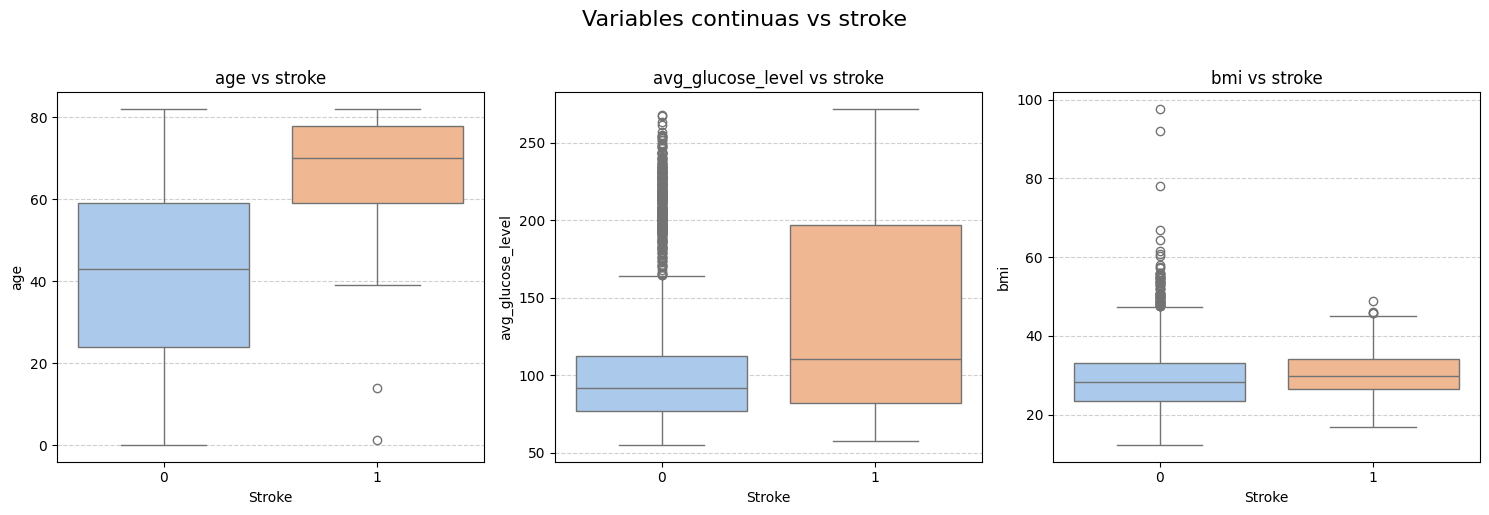

In [27]:
df_plot = df_combined[['stroke'] + numeric_features]

num_features = len(numeric_features)
n_cols = 3
n_rows = 1
plt.figure(figsize=(15, 5))
plt.suptitle('Variables continuas vs stroke', y=1.02, fontsize=16)
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(
        x='stroke',
        y=feature,
        data=df_plot,
        palette='pastel'
    )
    plt.title(f'{feature} vs stroke', fontsize=12)
    plt.xlabel('Stroke')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [28]:
df_combined['stroke_num'] = df_combined['stroke'].astype(int)

def test_mannwhitney(df, feature):
    grupo_no_stroke = df[df['stroke_num'] == 0][feature]
    grupo_si_stroke = df[df['stroke_num'] == 1][feature]
    stat, p_value = mannwhitneyu(grupo_no_stroke, grupo_si_stroke, alternative='two-sided')
    alpha = 0.05
    is_significant = 'Sí (p < 0.05)' if p_value < alpha else 'No (p >= 0.05)'
    return {
        'Estadístico U': stat,
        'P-Valor': p_value,
        'Significativo': is_significant
    }
results = {}
for feature in numeric_features:
    results[feature] = test_mannwhitney(df_combined, feature)

results_df_cont = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Feature'})
print(results_df_cont.to_markdown(index=False, floatfmt=".4f"))

| Feature           |   Estadístico U |   P-Valor | Significativo   |
|:------------------|----------------:|----------:|:----------------|
| age               |      72818.5000 |    0.0000 | Sí (p < 0.05)   |
| avg_glucose_level |     159040.5000 |    0.0000 | Sí (p < 0.05)   |
| bmi               |     180476.0000 |    0.0005 | Sí (p < 0.05)   |


Podemos ver que, tras aplicar el test de mann_whitney para comprobar si las diferencias entre las categorías respecto del target son significativas, en los tres casos hay diferencias significativas. Esto quiere decir que, en el caso de la edad, cuanto más mayor es el paciente, mayor es la proporción de strokes. Esto también se ve en el boxplot, en el cual solamente tenemos dos casos de stroke de personas menores de 20 años y todos los demás se encuentran de 40 años en adelante.

En el caso de los niveles de glucosa ocurre lo mismo, lo que pasa es que al haber tanto desbalance de clase, aparecen muchos "outliers" en la clase sin stroke.

Algo similar ocurre con el bmi, tenemos de nuevo muchos de estos "outliers" debido al desbalance de clase y si miramos la gráfica podemos ver como las cajas del diagrama están básicamente superpuestas, aunque si que es cierto que el rango de la clase 0 es mayor. Según el test esta relación es significativa pero debido a dicha superposición el bmi no va a ser un predictor fuerte.


Vamos a ver si ocurre algo extraño en nuestros datos de test y validación, viendo si tenemos valores extraños

In [29]:
X_val.nunique()

,0
gender,2
age,99
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,964
bmi,342
smoking_status,4


In [30]:
x_test.nunique()

,0
gender,2
age,92
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,968
bmi,318
smoking_status,4


Vemos que ni en test ni en validación tenemos valores extraños en ninguna variable

#### Preprocesamiento

En esta sección vamos a hacer el preprocesado de nuestro dataset antes de aplicar nuestros modelos. Primeramente vamos a transformar aquellas variables cuyas distribuciones tienen colas muy largas. Para ello vamos a aplicar una transformación logarítmica que conservará la naturaleza de la distribución original pero con colas más cortas. Después aplicaremos ohe a las variables categóricas para poder utilizarlas en nuestros modelos. Además, como tenemos un gran desbalance de clases, aplicaremos SMOTE en train para evitarlo y así predecir mejor los casos de stroke que son los que más nos importan.

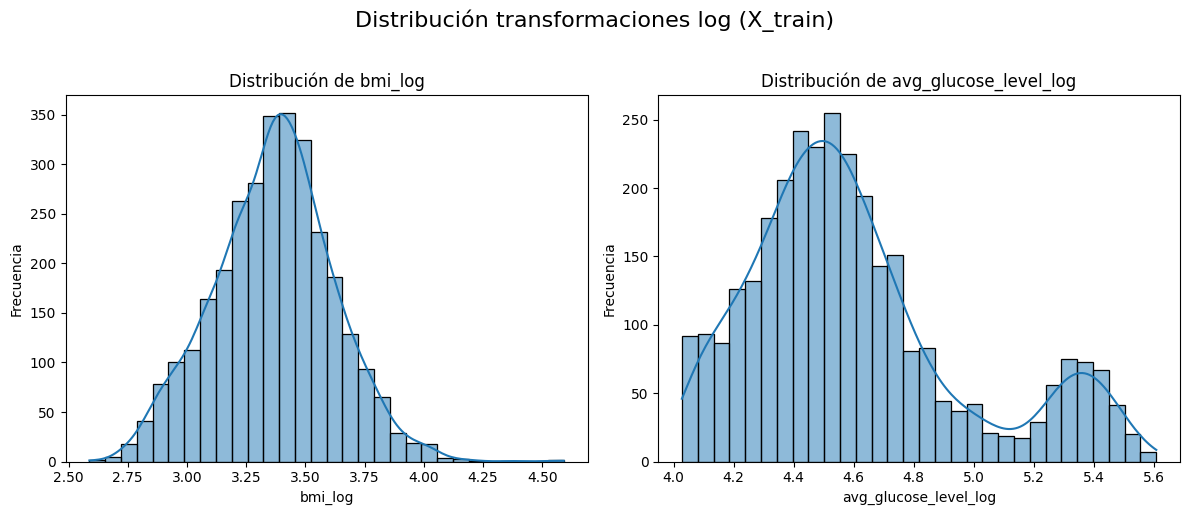

X_train_prep: (3066, 17)
X_val_prep:   (1022, 17)
x_test_prep:  (1022, 17)


,age,bmi_log,avg_glucose_level_log,gender,ever_married,Residence_type,hypertension,heart_disease,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4437,1.025212,-1.020586,2.108692,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
928,-0.871060,3.962788,-0.942274,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3946,-1.400252,-1.127937,-0.151919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1624,0.363722,-0.238414,-1.099372,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4991,0.010927,-0.209553,0.228308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
for df in [X_train, X_val, x_test]:
    # Aplicamos logaritmo
    df['bmi_log'] = np.log1p(df['bmi'])
    df['avg_glucose_level_log'] = np.log1p(df['avg_glucose_level'])

    # Eliminamos las columnas originales
    df.drop(columns=['bmi', 'avg_glucose_level'], inplace=True, errors='ignore')

# visualizamoss train para ver si hemos eliminado las colas
log_features = ['bmi_log', 'avg_glucose_level_log']
plt.figure(figsize=(12, 5))
plt.suptitle('Distribución transformaciones log (X_train)', y=1.02, fontsize=16)

for i, feature in enumerate(log_features):
    plt.subplot(1, 2, i + 1)
    sns.histplot(X_train[feature], kde=True, bins=30, palette='pastel')
    plt.title(f'Distribución de {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

numerical_cols_final = ['age', 'bmi_log', 'avg_glucose_level_log']
binary_cat_cols = ['gender', 'ever_married', 'Residence_type', 'hypertension', 'heart_disease']
multi_cat_cols = ['work_type', 'smoking_status']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_final),
        # binarias a 1 o 0
        ('ord', OrdinalEncoder(), binary_cat_cols),
        # ohe para las multiclase
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cat_cols)
    ],
    verbose_feature_names_out=False
).set_output(transform="pandas")

# ajustamos solo en train pero transformamos test y val
X_train_prep = preprocessor.fit_transform(X_train)

X_val_prep = preprocessor.transform(X_val)
x_test_prep = preprocessor.transform(x_test)

print(f"X_train_prep: {X_train_prep.shape}")
print(f"X_val_prep:   {X_val_prep.shape}")
print(f"x_test_prep:  {x_test_prep.shape}")

display(X_train_prep.head())

In [32]:
print(X_train_prep.isnull().sum())

age                               0
bmi_log                           0
avg_glucose_level_log             0
gender                            0
ever_married                      0
Residence_type                    0
hypertension                      0
heart_disease                     0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


Por último vamos a solventar nuestro fuerte desbalance de clase utilizando SMOTE en train.

In [33]:
print("Distribución antes de SMOTE ")
counter_before = Counter(y_train)
print(counter_before)
smote = SMOTE(random_state=123, sampling_strategy='auto')

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_prep, y_train)

# verificamos
print("\nDistribución después de SMOTE")
counter_after = Counter(y_train_resampled)
print(counter_after)

print(f"\nDimensiones de X_train original: {X_train_prep.shape}")
print(f"Dimensiones de X_train con SMOTE: {X_train_resampled.shape}")

Distribución antes de SMOTE 
Counter({0: 2917, 1: 149})

Distribución después de SMOTE
Counter({0: 2917, 1: 2917})

Dimensiones de X_train original: (3066, 17)
Dimensiones de X_train con SMOTE: (5834, 17)


In [34]:
print(X_train_resampled.isnull().sum())

age                               0
bmi_log                           0
avg_glucose_level_log             0
gender                            0
ever_married                      0
Residence_type                    0
hypertension                      0
heart_disease                     0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


## ***Sección II. Esquema lineal y selección de características.***

En esta sección abordaremos nuestra tarea de clasificación mediante el uso primero de un esquema de regresión logística con todas las variables y sin usar ningún tipo de regularización, para después compararlo con modelos en los que aplicaremos regularización y selección de características.

### Regresión logística básica

He decidido primeramente hacer una comparativa entre el modelo con todas las variables aplicando SMOTE y el modelo sin aplicarlo, para ver qué impacto tiene en las predicciones del modelo.

Modelo sin SMOTE
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022


Modelo con SMOTE
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.13      0.78      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.74      0.81      1022

AUC: 0.758312757201646


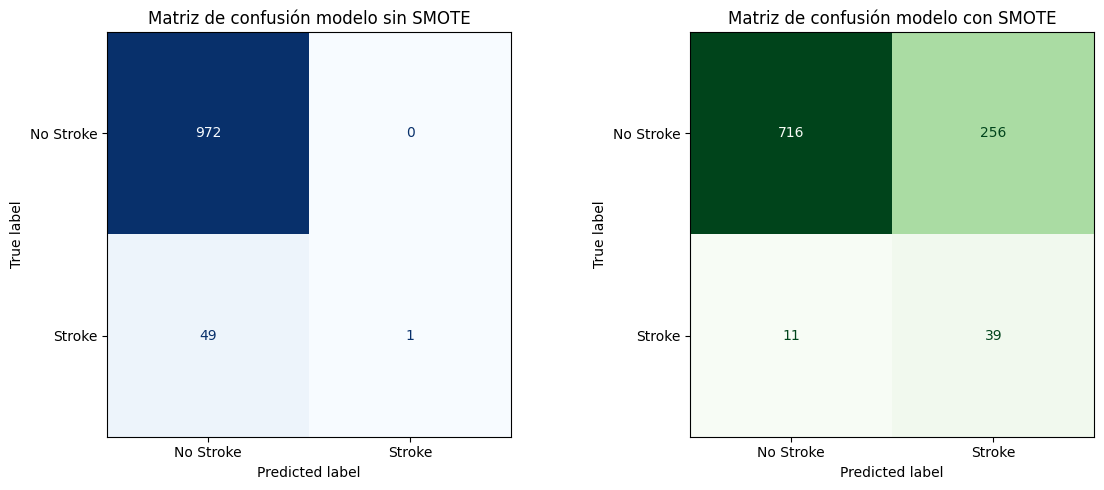

In [35]:

# Modelo sin smote (desbalanceado)
log_reg_base = LogisticRegression(penalty=None, random_state=123, max_iter=5000)
log_reg_base.fit(X_train_prep, y_train)

# modelo con smote
log_reg_smote = LogisticRegression(penalty=None, random_state=123, max_iter=5000)
log_reg_smote.fit(X_train_resampled, y_train_resampled)


print("Modelo sin SMOTE")
y_pred_val_base = log_reg_base.predict(X_val_prep)
print(classification_report(y_val, y_pred_val_base))

print("\nModelo con SMOTE")
y_pred_val_smote = log_reg_smote.predict(X_val_prep)
print(classification_report(y_val, y_pred_val_smote))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz confusión modelo sin smote
cm_base = confusion_matrix(y_val, y_pred_val_base)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=['No Stroke', 'Stroke'])
disp_base.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Matriz de confusión modelo sin SMOTE')

# Matriz confusion modelo smote
cm_smote = confusion_matrix(y_val, y_pred_val_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['No Stroke', 'Stroke'])
disp_smote.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('Matriz de confusión modelo con SMOTE')
auc = roc_auc_score(y_val, y_pred_val_smote)
print(f"AUC: {auc}")
plt.tight_layout()
plt.show()

Cuando comparamos las matrices de confusión de ambos modelos, podemos observar el impacto que tiene el desbalanceo de clases sobre nuestro modelo. En el caso sin SMOTE, vemos que el modelo clasifica perfectamente todas las observaciones de la clase mayoritaria (aquellos que no tienen un stroke) pero falla al predecir los casos de ictus reales, con un 0% de recall y solamente prediciendo 1/50 casos.

En cambio el modelo con SMOTE es peor prediciendo a aquellos que no tienen un ictus, ya que tenemos un mayor número de falsos positivos. A cambio, tiene un recall mucho mayor, de un 78%, lo cual significa que predice mucho mejor los verdaderos positivos. Esto en un contexto médico es preferible, priorizamos el no perder casos positivos sobre la precisión, ya que el coste de no detectar un ictus siempre va a ser mayor que el coste de hacer más pruebas a alguien sano

### Regresión logística con regularización y selección de variables

A continuación vamos a aplicar regularización. Para ello vamos a utilizar regularización L1, L2 y Elastic Net para poderlas comparar y elegir la que mejor se auste a nuestro modelo. Para compararlos vamos a utilizar el F1-score ya que es la figura de mérito con mejor balance entre precisión y recall, pudiendo así elegir el modelo con mejor equilibrio. Utilizar otras como accuracy (nos dice que el modelo es bueno aunque no prediga bien lo que nosotros queremos) o recall (en medicina es ideal, pero solo usar esta métrica puede dar lugar a un modelo que diga que todo el mundo tiene un ictus) no va a darnos tan buen resultado

,Recall,Precision,F1-score,ROC-AUC,Specificity,Mejores parámetros
Modelo,,,,,,
Elastic Net,0.780000,0.130000,0.222857,0.833539,0.731481,"{'C': 0.1, 'l1_ratio': 0.5}"
Ridge (L2),0.780000,0.129568,0.222222,0.832716,0.730453,{'C': 0.1}
Lasso (L1),0.780000,0.129139,0.221591,0.834218,0.729424,{'C': 0.1}


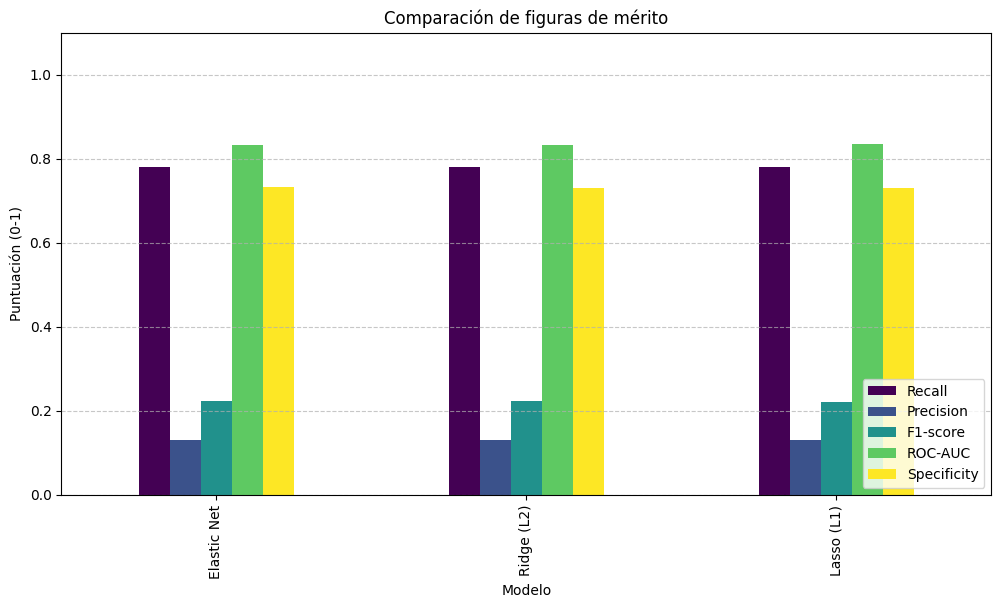

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    roc_auc_score
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models_to_test = {
    'Lasso (L1)': {
        'model': LogisticRegression(penalty='l1', solver='saga', random_state=123, max_iter=5000),
        'params': {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100]}
    },
    'Ridge (L2)': {
        'model': LogisticRegression(penalty='l2', solver='saga', random_state=123, max_iter=5000),
        'params': {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100]}
    },
    'Elastic Net': {
        'model': LogisticRegression(penalty='elasticnet', solver='saga', random_state=123, max_iter=5000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'l1_ratio': [0.2, 0.5, 0.8]
        }
    }
}

results = []
best_estimators = {}

for name, config in models_to_test.items():
    # Grid search optimizando F1
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    grid.fit(X_train_resampled, y_train_resampled)
    best_model = grid.best_estimator_
    best_estimators[name] = best_model

    y_pred_val = best_model.predict(X_val_prep)
    y_proba_val = best_model.predict_proba(X_val_prep)[:, 1]

    # calculamos las figuras de merito
    recall = recall_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_proba_val)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
    specificity = tn / (tn + fp)

    best_params = grid.best_params_

    results.append({
        'Modelo': name,
        'Recall': recall,
        'Precision': precision,
        'F1-score': f1,
        'ROC-AUC': auc,
        'Specificity': specificity,
        'Mejores parámetros': str(best_params)
    })

results_df = pd.DataFrame(results).set_index('Modelo').sort_values(by='F1-score', ascending=False)

display(results_df.style.background_gradient(cmap='Blues'))

results_df[['Recall', 'Precision', 'F1-score', 'ROC-AUC', 'Specificity']].plot(
    kind='bar', figsize=(12, 6), colormap='viridis', ylim=(0, 1.1)
)
plt.title('Comparación de figuras de mérito')
plt.ylabel('Puntuación (0-1)')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 500x400 with 0 Axes>

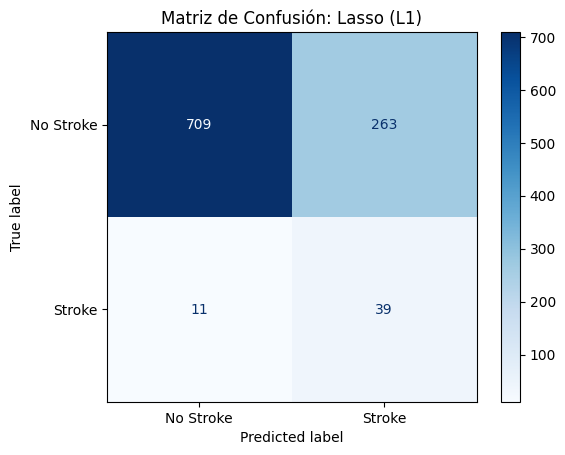

  - TP: 39
  - FN: 11
  - FP: 263


<Figure size 500x400 with 0 Axes>

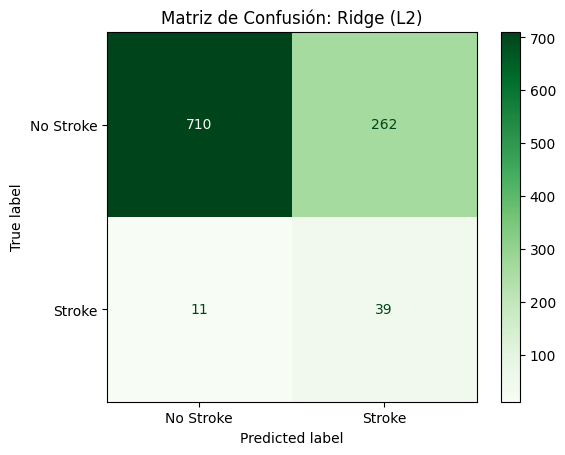

  - TP: 39
  - FN: 11
  - FP: 262


<Figure size 500x400 with 0 Axes>

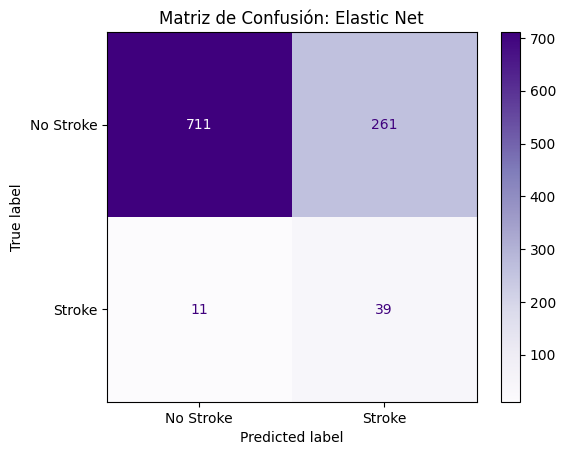

  - TP: 39
  - FN: 11
  - FP: 261


In [37]:
for name, model in best_estimators.items():
    y_pred = model.predict(X_val_prep)
    # Generamos la matriz
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])

    cmap_color = 'Blues' if 'Lasso' in name else ('Greens' if 'Ridge' in name else 'Purples')

    disp.plot(cmap=cmap_color, values_format='d')
    plt.title(f'Matriz de Confusión: {name}')
    plt.show()

    print(f"  - TP: {tp}")
    print(f"  - FN: {fn}")
    print(f"  - FP: {fp}")


Hemos utilizado 5 figuras de mérito para comparar los diferentes modelos de regularización: recall, precision, F1-score, AUC y specificity. Podemos ver que los tres modelos tienen resultados muy similares, pero el modelo Elastic net es el mejor en 3 de estas categorías, en AUC es el segundo y en recall todos tienen el mismo resultado. La diferencia entre Elastic net y los otros dos es que elastic net tiene menos FP, eso si, la diferencia es prácticamente inexistente

Mejor modelo: Elastic Net
Figuras de mérito:
 - Recall: 0.7800
 - Precision: 0.1300
 - F1-Score:0.2229
 - ROC-AUC: 0.8335
 - Specificity:0.7315
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.13      0.78      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022

                           Feature  Coefficient
0                              age     1.965471
12              work_type_children     1.056996
6                     hypertension     0.644202
8               work_type_Govt_job    -0.571236
11         work_type_Self-employed    -0.459661
3                           gender    -0.404035
15     smoking_status_never smoked    -0.341777
16           smoking_status_smokes     0.323446
5                   Residence_type     0.310904
2            avg_glucose_level_log     0.236924
1

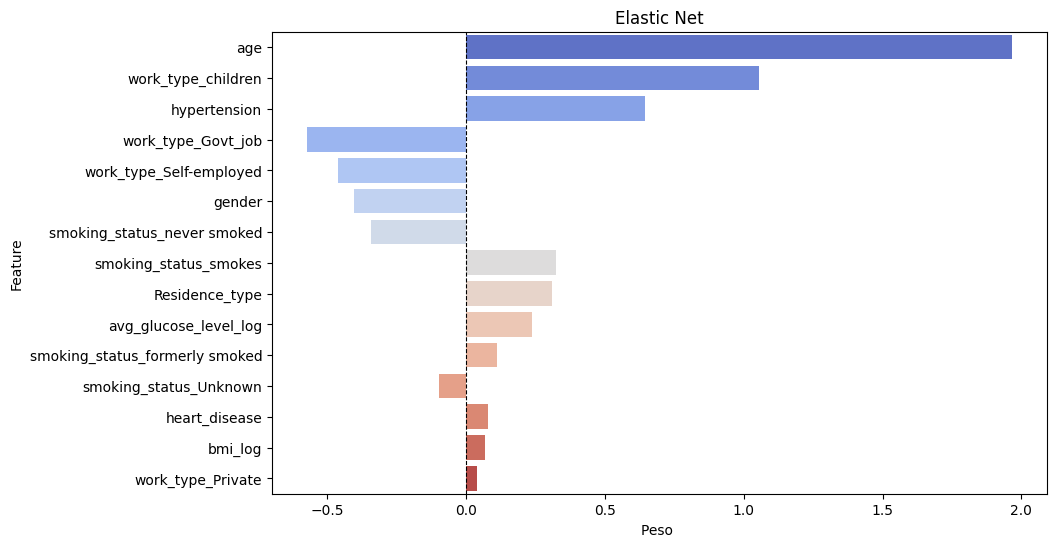

In [38]:
best_reg_name = results_df.index[0]
best_reg_model = best_estimators[best_reg_name]

print(f"Mejor modelo: {best_reg_name}")

y_pred_final = best_reg_model.predict(X_val_prep)
y_proba_final = best_reg_model.predict_proba(X_val_prep)[:, 1]

recall = recall_score(y_val, y_pred_final)
precision = precision_score(y_val, y_pred_final)
f1 = f1_score(y_val, y_pred_final)
auc = roc_auc_score(y_val, y_proba_final)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_final).ravel()
specificity = tn / (tn + fp)

print(f"Figuras de mérito:")
print(f" - Recall: {recall:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - F1-Score:{f1:.4f}")
print(f" - ROC-AUC: {auc:.4f}")
print(f" - Specificity:{specificity:.4f}")

print(classification_report(y_val, y_pred_final))

# vamos a ver los coeficientes
coefs_df = pd.DataFrame({
    'Feature': X_train_prep.columns,
    'Coefficient': best_reg_model.coef_[0],
    'Abs_Coef': abs(best_reg_model.coef_[0])
})

coefs_df = coefs_df.sort_values(by='Abs_Coef', ascending=False)

print(coefs_df[['Feature', 'Coefficient']].head(18))

plt.figure(figsize=(10, 6))
sns.barplot(data=coefs_df.head(15), x='Coefficient', y='Feature', palette='coolwarm')
plt.title(f'{best_reg_name}')
plt.xlabel('Peso ')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()

Aquí podemos ver un resumen del modelo de regularización elastic net con las figuras de mérito. Podemos destacar la baja precision del modelo, esto tiene que ver con que clasifica a muchas más personas con ictus de las que realmente lo tienen. Esto es algo que debemos tratar de mejorar con los siguientes modelos. A pesar de ello, el recall es bastante alto por lo que detectamos a los pacientes con ictus pero seguimos teniendo mucho ruido. También podemos ver los coeficientes del modelo, el más importante en este caso es la edad con bastante diferencia, seguido de que sea un niño y la hipertensión. Ha eliminado la variable never worked y le da muy poca importancia a que sea un trabajador en una empresa privada y sorprendentemente al bmi y a heart disease. Lo del bmi no sorprende tanto ya que en el EDA pudimos ver como la diferencia no era muy grande pero las enfermedades cardiacas si tenian que ver con el riesgo de ictus.

Ahora vamos a hacer una selección de características mediante métodos wrapper y aplicaremos de nuevo un modelo de regresión logística.

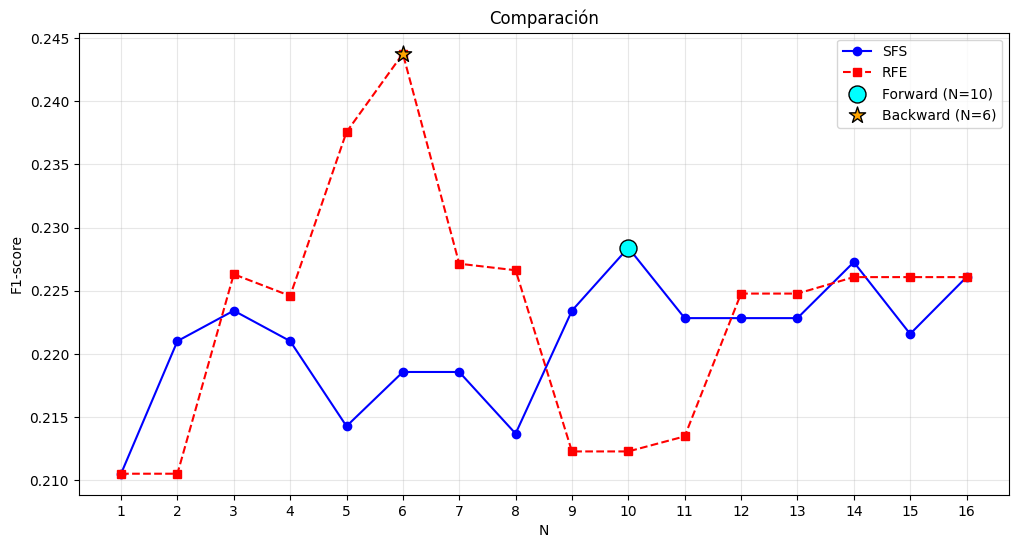

Mejor SFS: N=10 | F1=0.2284
Mejor RFE: N=6 | F1=0.2438


In [42]:
total_features = X_train_resampled.shape[1]
feature_range = range(1, total_features)

scores_forward = []
scores_backward = []

base_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000, random_state=123)

for n in feature_range:
    sfs = SequentialFeatureSelector(
        base_model,
        n_features_to_select=n,
        direction='forward',
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
    sfs.fit(X_train_resampled, y_train_resampled)

    # metodo forwards, empezamos con una variable y vamos añadiendo
    mask_fw = sfs.get_support()
    X_tr_fw = X_train_resampled.iloc[:, mask_fw]
    X_val_fw = X_val_prep.iloc[:, mask_fw]

    clf_fw = LogisticRegression(penalty=None, max_iter=5000, random_state=123)
    clf_fw.fit(X_tr_fw, y_train_resampled)
    f1_fw = f1_score(y_val, clf_fw.predict(X_val_fw))
    scores_forward.append(f1_fw)

    # método backwards, empezamos con todas las variables y vamos eliminando
    rfe = RFE(
        estimator=base_model,
        n_features_to_select=n,
        step=1
    )
    rfe.fit(X_train_resampled, y_train_resampled)
    mask_bw = rfe.get_support()
    X_tr_bw = X_train_resampled.iloc[:, mask_bw]
    X_val_bw = X_val_prep.iloc[:, mask_bw]

    clf_bw = LogisticRegression(penalty=None, max_iter=5000, random_state=123)
    clf_bw.fit(X_tr_bw, y_train_resampled)
    f1_bw = f1_score(y_val, clf_bw.predict(X_val_bw))
    scores_backward.append(f1_bw)


plt.figure(figsize=(12, 6))

plt.plot(feature_range, scores_forward, marker='o', linestyle='-', color='blue', label='SFS')
plt.plot(feature_range, scores_backward, marker='s', linestyle='--', color='red', label='RFE')

# guardamos los max
best_idx_fw = np.argmax(scores_forward)
best_idx_bw = np.argmax(scores_backward)

plt.scatter(feature_range[best_idx_fw], scores_forward[best_idx_fw], s=150, c='cyan', edgecolors='black', zorder=5, label=f'Forward (N={feature_range[best_idx_fw]})')
plt.scatter(feature_range[best_idx_bw], scores_backward[best_idx_bw], s=150, c='orange', edgecolors='black', zorder=5, marker='*', label=f'Backward (N={feature_range[best_idx_bw]})')

plt.title('Comparación')
plt.xlabel('N')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(feature_range)
plt.show()

# seleccionamos el mejor modelo
f1_best_fw = scores_forward[best_idx_fw]
f1_best_bw = scores_backward[best_idx_bw]

print(f"Mejor SFS: N={feature_range[best_idx_fw]} | F1={f1_best_fw:.4f}")
print(f"Mejor RFE: N={feature_range[best_idx_bw]} | F1={f1_best_bw:.4f}")


In [47]:
if f1_best_fw >= f1_best_bw:
    winner_name = "Sequential Forward Selection (SFS)"
    final_selector = SequentialFeatureSelector(
        base_model,
        n_features_to_select=feature_range[best_idx_fw],
        direction='forward',
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
else:
    winner_name = "Recursive Feature Elimination (RFE)"
    final_selector = RFE(
        estimator=base_model,
        n_features_to_select=feature_range[best_idx_bw],
        step=1
    )

final_selector.fit(X_train_resampled, y_train_resampled)

selected_mask = final_selector.get_support()
final_feature_names = X_train_prep.columns[selected_mask]

print(f"\nVariables seleccionadas:")
for i, feature in enumerate(final_feature_names, 1):
    print(f"{i}. {feature}")

selected_features_wrapper = list(final_feature_names)


Variables seleccionadas:
1. age
2. hypertension
3. work_type_Govt_job
4. work_type_Self-employed
5. work_type_children
6. smoking_status_never smoked


Podemos ver que el mejor modelo es el que utiliza backwards elimination y utiliza 6 variables:
1. age
2. hypertension
3. work_type_Govt_job
4. work_type_Self-employed
5. work_type_children
6. smoking_status_never smoked

El uso de estas variables tiene sentido ya que son a las que el modelo de regularización daba una mayor importancia, y elimina las variables que no eran tan importantes a la hora de tener un buen modelo.

Vamos a ver sus figuras de mérito para evaluar como de bueno es realmente el modelo

 - Recall: 0.8800
 - Precision: 0.1415
 - F1-Score: 0.2438
 - ROC-AUC: 0.8421
 - Specificity: 0.7253
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.14      0.88      0.24        50

    accuracy                           0.73      1022
   macro avg       0.57      0.80      0.54      1022
weighted avg       0.95      0.73      0.81      1022



<Figure size 600x500 with 0 Axes>

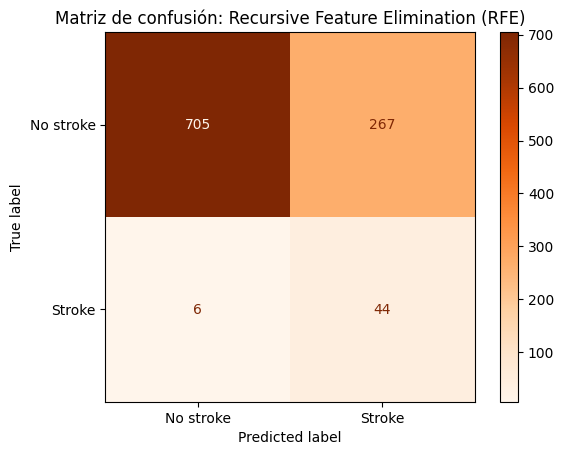

 - TP: 44
 - FN: 6
 - FP: 267


In [48]:
# hacemos la prediccion con las variables seleccionadas
X_train_final_wrapper = X_train_resampled.iloc[:, selected_mask]
X_val_final_wrapper = X_val_prep.iloc[:, selected_mask]

model_wrapper_final = LogisticRegression(penalty=None, max_iter=5000, random_state=123)
model_wrapper_final.fit(X_train_final_wrapper, y_train_resampled)

y_pred_wrapper = model_wrapper_final.predict(X_val_final_wrapper)
y_proba_wrapper = model_wrapper_final.predict_proba(X_val_final_wrapper)[:, 1]
# calculamos las figuras de merito
recall = recall_score(y_val, y_pred_wrapper)
precision = precision_score(y_val, y_pred_wrapper)
f1 = f1_score(y_val, y_pred_wrapper)
auc = roc_auc_score(y_val, y_proba_wrapper)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_wrapper).ravel()
specificity = tn / (tn + fp)
# las imprimimos
print(f" - Recall: {recall:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - F1-Score: {f1:.4f}")
print(f" - ROC-AUC: {auc:.4f}")
print(f" - Specificity: {specificity:.4f}")

print(classification_report(y_val, y_pred_wrapper))
# imprimimos la matriz de confusion
cm = confusion_matrix(y_val, y_pred_wrapper)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No stroke', 'Stroke'])
disp.plot(cmap='Oranges', values_format='d')
plt.title(f'Matriz de confusión: {winner_name}')
plt.show()

print(f" - TP: {tp}")
print(f" - FN: {fn}")
print(f" - FP: {fp}")

Vemos que este modelo predice mejor aún los casos positivos de stroke, aunque es verdad que tiene un mayor número de falsos positivos frente a modelos anteriores

## ***Sección III. Perceptrón Multicapa o MLP (Multi-Layer Perceptron)***

En esta sección vamos a abordar la implementación de un MLP, primero con una única capa oculta, después con varias y por último utilizaremos selección de características para encontrar el mejor modelo posible.

Respondiendo a si es razonable o no diseñar un MLP con una sola capa oculta, en nuestro caso lo es. Si nos basamos en la definición de MLP como aproximador universal, si tenemos un número de neuronas suficiente y una función de activación no lineal capaz de aproximar funciones continuas con la precisión deseada, no es necesario añadir más capas, bastaría con añadir neuronas a nuestra capa. Asimismo, como nuestros datos son tabulares y no de reconocimiento de imágenes o NLP, donde se necesitan más capas para entender jerarquías en los datos, con una sola capa podemos capturar las no linearidades de las interacciones entre variables. Además, cumpliendo con el principio de parsimonia, un modelo más simple es preferible sobre uno complejo siempre y cuando el resultado sea suficientemente bueno.

En cuanto al MLP como aproximador universal, este teorema nos dice que una red neuronal feedforward con una sola capa oculta, neuronas finitas y funciones de activación no lineales puede aproximar cualquier función matemática que reciba unas entradas y las mapee a unas salidas.

En nuestro conjunto de observaciones, esta función desconocida es la relación entre factores médicos y biológicos que determinan si una persona sufrirá o no un ictus. La entrada son nuestras características para un paciente y la salida es si sufre o no un ictus. Siguiendo este principio, con nuestra aproximación,aunque compleja debido a que no existe una frontera claramente definida entre alguien sano y alguien que va a tener un ictus, nos garantiza que existe una configuración de pesos en el MLP que pueda dibujar dicha frontera, capturando relaciones no lineales y complejas entre las variables.

Normalizar es clave en un MLP. En este modelo, las neuronas hacen sumas ponderadas de las entradas, si tuvieramos variables muy grandes comparadas con otras muy pequeñas, el modelo ignoraría las pequeñas y tendría solo en cuenta las grandes. Además, en el algoritmo de backpropagation, al aplicar descenso por gradiente si las variables no están normalizadas, se encontrará con valles muy estrechos, dificultando el aprendizaje. Por último, unos datos no normalizados hacen que nuestra función de activación funcione mal.

Vamos a entrenar un MLP de una única capa

Cuando hicimos el preprocesamiento en la sección I ya hicimos un escalado utilizando StandardScaler. Vamos a utilizar el F1-score de nuevo como figura de mérito en función de la cual evaluaremos los modelos a la hora de entrenarlos. Elegimos esta ya que tiene un balance entre Recall y Precision que es clave en nuestro análisis ya que lo que queremos es acertar lo máximo posible en los casos de stroke (Recall) mientras que tratamos de minimizar los falsos positivos (Precision)

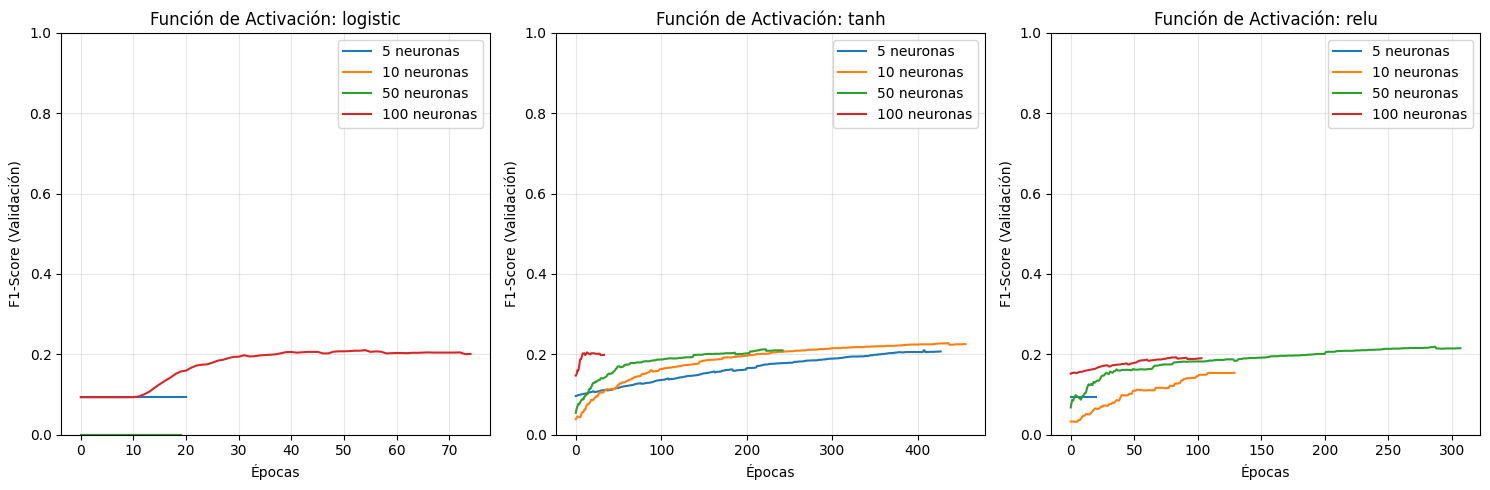

Mejor modelo: tanh - 10 neuronas


In [50]:
# definimos diferentes numeros de neuronas y las diferentes funciones de activación
# que vamos a probar
neurons_list = [5, 10, 50, 100]
activations = ['logistic', 'tanh', 'relu']

# Parámetros fijos para cumplir requisitos
MAX_EPOCHS = 1000
BATCH_SIZE = X_train_resampled.shape[0]

results_history = {}
best_score_global = 0
best_model_config = None
best_mlp_model = None

plt.figure(figsize=(15, 5))

for i, act in enumerate(activations):
    plt.subplot(1, 3, i+1)

    for neurons in neurons_list:
        # usamos descenso por gradiente
        mlp = MLPClassifier(
            hidden_layer_sizes=(neurons,),
            activation=act,
            solver='sgd',
            learning_rate_init=0.01, # Tasa de aprendizaje fija
            batch_size=BATCH_SIZE,
            max_iter=1,
            warm_start=True, # mantenemos los pesos para la siguiente it
            random_state=123
        )

        f1_scores_val = []
        patience = 20
        no_improve = 0
        best_val_f1 = 0

        for epoch in range(MAX_EPOCHS):
            mlp.fit(X_train_resampled, y_train_resampled)
            y_pred_val = mlp.predict(X_val_prep)
            current_f1 = f1_score(y_val, y_pred_val)
            f1_scores_val.append(current_f1)
            if current_f1 > best_val_f1:
                best_val_f1 = current_f1
                no_improve = 0
                if current_f1 > best_score_global:
                    best_score_global = current_f1
                    best_model_config = f"{act} - {neurons} neuronas"
                    best_mlp_model = mlp
            else:
                no_improve += 1
            if no_improve >= patience:
                break

        plt.plot(f1_scores_val, label=f'{neurons} neuronas')
    plt.title(f'Función de Activación: {act}')
    plt.xlabel('Épocas')
    plt.ylabel('F1-Score (Validación)')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Mejor modelo: {best_model_config}")


 - Recall: 0.9000
 - Precision: 0.1289
 - F1-Score: 0.2256
 - ROC-AUC: 0.8347
 - Specificity: 0.6872
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       972
           1       0.13      0.90      0.23        50

    accuracy                           0.70      1022
   macro avg       0.56      0.79      0.52      1022
weighted avg       0.95      0.70      0.78      1022



<Figure size 500x400 with 0 Axes>

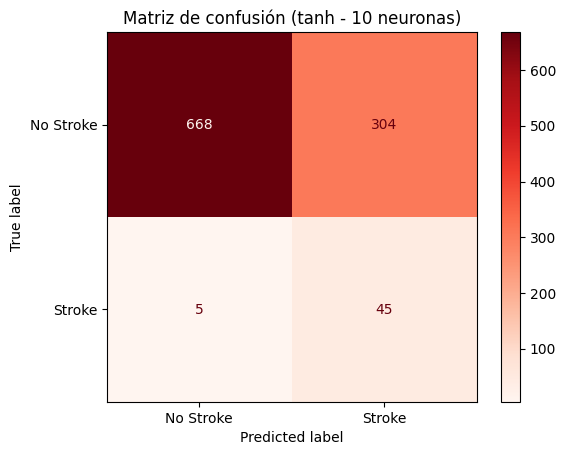

 - TP: 45
 - FN: 5
 - FP: 304


In [52]:
# prededcimos en val
y_pred_mlp = best_mlp_model.predict(X_val_prep)
y_proba_mlp = best_mlp_model.predict_proba(X_val_prep)[:, 1]

recall_mlp = recall_score(y_val, y_pred_mlp)
precision_mlp = precision_score(y_val, y_pred_mlp)
f1_mlp = f1_score(y_val, y_pred_mlp)
auc_mlp = roc_auc_score(y_val, y_proba_mlp)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_mlp).ravel()
specificity_mlp = tn / (tn + fp)

print(f" - Recall: {recall_mlp:.4f}")
print(f" - Precision: {precision_mlp:.4f}")
print(f" - F1-Score: {f1_mlp:.4f}")
print(f" - ROC-AUC: {auc_mlp:.4f}")
print(f" - Specificity: {specificity_mlp:.4f}")

print(classification_report(y_val, y_pred_mlp))

# Matriz de Confusión
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred_mlp), display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Reds', values_format='d')
plt.title(f'Matriz de confusión ({best_model_config})')
plt.show()

print(f" - TP: {tp}")
print(f" - FN: {fn}")
print(f" - FP: {fp}")

Podemos ver como nuestro modelo tiene una recall muy alta, es decir, predice muy bien los casos de stroke lo cual es muy positivo para nuestro análisis. En cambio vemos que tiene de nuevo una precision muy baja ya que dice que un tercio de las personas que realmente no tienen un stroke, si que lo tienen. Es por ello que el F1-score es bajo, ya que es la relación entre recall y precision. También tenemos un AUC bastante grande ya que predecimos muy bien los TP y decentemente los TN. Con los modelos que implementaremos a continuación intentaremos mejorar la precison a la vez que intentamos mantener la mejor recall posible.

Vamos a entrenar un MLP con capas ocultas. En este caso no utilizaremos la función sigmoide ya que al aplicar backpropagation, su derivada es casi cero, cuando ajustamos la primera capa multiplicamos las deriivadas de las 4 capas siguientes y nos queda un gradiente casi nulo, por lo que los pesos casi no se van a mover. Lo más probable es que la ReLu sea la mejor función, pero debemos comprobarlo a continuación

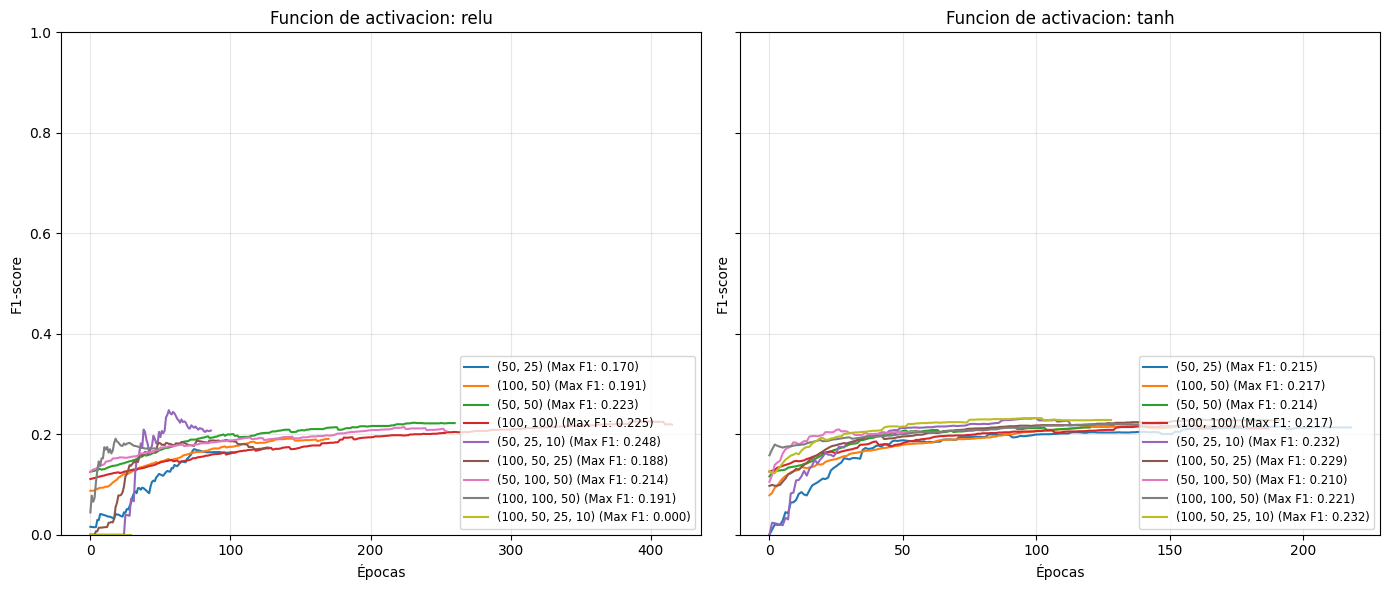

Mejor modelo: Activación: relu | Arquitectura: (50, 25, 10)
 - Recall: 0.8400
 - Precision: 0.1183
 - F1-Score: 0.2074
 - ROC-AUC: 0.8265
 - Specificity: 0.6780
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       972
           1       0.12      0.84      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.76      0.51      1022
weighted avg       0.95      0.69      0.77      1022



In [53]:
# Vamos a definit diferentes modelos con numeros distintos de capas y de neuronas para cada capa
deep_architectures = [
    (50, 25),
    (100, 50),
    (50, 50),
    (100, 100),
    (50, 25, 10) ,
    (100, 50, 25),
    (50, 100, 50),
    (100, 100, 50),
    (100, 50, 25, 10)
]

activations = ['relu', 'tanh']

BATCH_SIZE = X_train_resampled.shape[0]

# configuramos el numero de epocas
MAX_EPOCHS = 1000
PATIENCE = 30

best_score_global = 0
best_model_config = ""
best_mlp_deep_model = None

fig, axes = plt.subplots(1, len(activations), figsize=(14, 6), sharey=True)
if len(activations) == 1: axes = [axes]
for i, act in enumerate(activations):
    ax = axes[i]

    for arch in deep_architectures:
        # Inicializamos el modelo
        mlp = MLPClassifier(
            hidden_layer_sizes=arch,
            activation=act,
            solver='sgd',
            batch_size=BATCH_SIZE,
            learning_rate_init=0.01,
            max_iter=1,
            warm_start=True,
            random_state=123
        )

        f1_history = []
        best_val_local = 0
        no_improve = 0

        for epoch in range(MAX_EPOCHS):
            mlp.fit(X_train_resampled, y_train_resampled)

            y_pred = mlp.predict(X_val_prep)
            current_f1 = f1_score(y_val, y_pred)
            f1_history.append(current_f1)

            if current_f1 > best_score_global:
                best_score_global = current_f1
                best_model_config = f"Activación: {act} | Arquitectura: {arch}"
                best_mlp_deep_model = mlp

            if current_f1 > best_val_local:
                best_val_local = current_f1
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= PATIENCE:
                break

        ax.plot(f1_history, label=f'{arch} (Max F1: {best_val_local:.3f})')

    ax.set_title(f'Funcion de activacion: {act}')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('F1-score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right', fontsize='small')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejor modelo: {best_model_config}")

# Predicciones finales con dicho modelo
y_pred_deep = best_mlp_deep_model.predict(X_val_prep)
y_proba_deep = best_mlp_deep_model.predict_proba(X_val_prep)[:, 1]

# Figuras de merito
recall = recall_score(y_val, y_pred_deep)
precision = precision_score(y_val, y_pred_deep)
f1 = f1_score(y_val, y_pred_deep)
auc = roc_auc_score(y_val, y_proba_deep)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_deep).ravel()
specificity = tn / (tn + fp)

print(f" - Recall: {recall:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - F1-Score: {f1:.4f}")
print(f" - ROC-AUC: {auc:.4f}")
print(f" - Specificity: {specificity:.4f}")

print(classification_report(y_val, y_pred_deep))

El mejor modelo finalmente ha sido con una ReLu con 3 capas de 50, 25 y 10 neuronas respectivamente, en forma de embudo. Este modelo es peor que el MLP de una sola capa ya que tiene peor recall, una precision peor también, peor AUC, peor specificity y peor F1. Es simplemente un modelo que predice peor a pesar de tener más capas y más neuronas en total.

<Figure size 500x400 with 0 Axes>

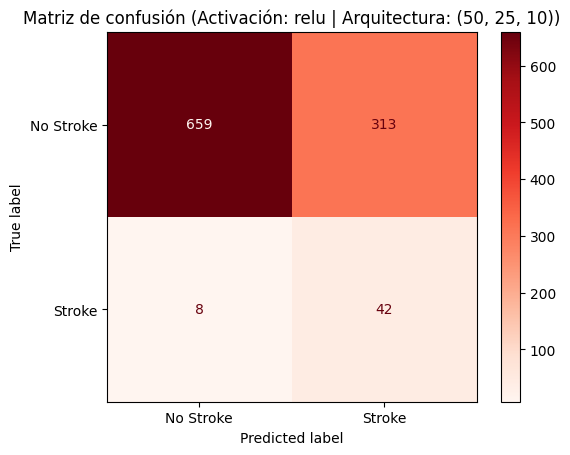

 - TP: 42
 - FN: 8
 - FP: 313


In [54]:
# Matriz de confusión
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred_deep), display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Reds', values_format='d')
plt.title(f'Matriz de confusión ({best_model_config})')
plt.show()

print(f" - TP: {tp}")
print(f" - FN: {fn}")
print(f" - FP: {fp}")

Como podemos ver en la matriz de confusión como tenemos menos strokes bien predichos y más casos de gente sin stroke predichos como stroke, como hemos dicho anteriormente, el modelo es peor que el de 1 capa.

Por último vamos a utilizar un método wrapper con un MLP para hacer selección de características, tanto para un modelo de una capa, como para un modelo con más capas.

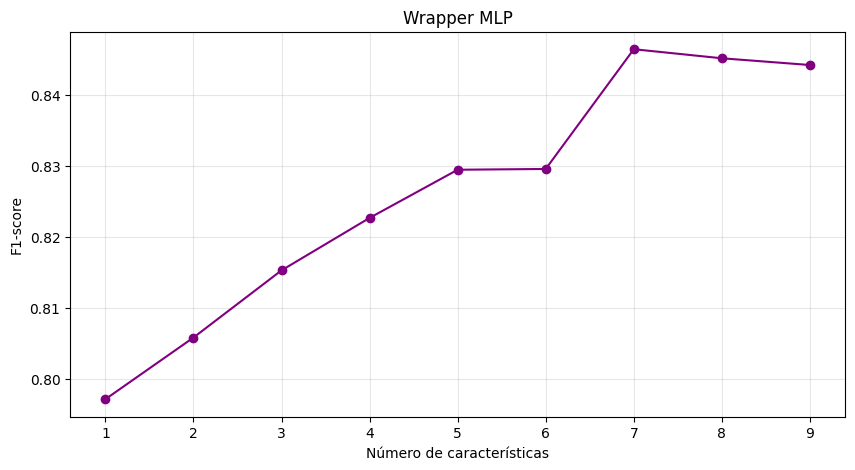


N optimo: 7
Variables seleccionadas (7):
['age', 'bmi_log', 'avg_glucose_level_log', 'gender', 'Residence_type', 'work_type_children', 'smoking_status_smokes']
 - Recall: 0.7800
 - Precision: 0.1242
 - F1-score: 0.2143
 - ROC-AUC: 0.8331
 - Specificity: 0.7171
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.78      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.72      0.80      1022



<Figure size 500x400 with 0 Axes>

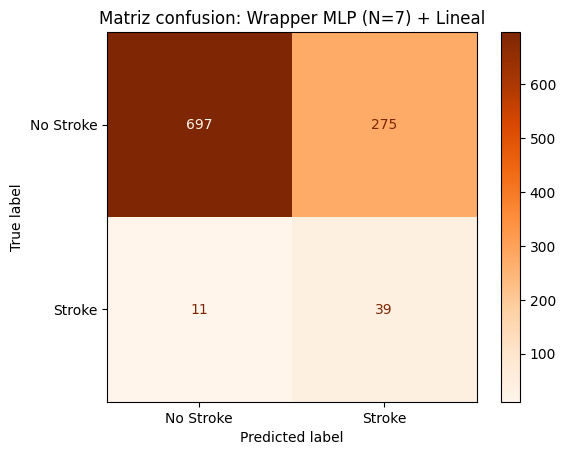

 - TP: 39
 - FN: 11


In [55]:
# lo hacemos con un MLP "básico" por motivoos computacionales
mlp_selector = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=123
)

# vamos a utilizar un máximo de 10 variables para que no tarde horas en entrenarse
# elegimos 10 como máximo por los resultados del modelo lineal con seleccion de variables
total_available = X_train_resampled.shape[1]
feature_range = range(1, 10)

scores_mlp_wrapper = []
best_n_mlp = 0
best_score_mlp = 0
best_features_mlp = []

for n in feature_range:
    sfs = SequentialFeatureSelector(
        mlp_selector,
        n_features_to_select=n,
        direction='forward',
        scoring='f1',
        cv=3,
        n_jobs=-1
    )

    sfs.fit(X_train_resampled, y_train_resampled)
    mask = sfs.get_support()
    selected_cols = X_train_prep.columns[mask]

    X_subset = X_train_resampled.iloc[:, mask]

    cv_scores = cross_val_score(
        mlp_selector,
        X_subset,
        y_train_resampled,
        cv=3,
        scoring='f1'
    )
    mean_score = np.mean(cv_scores)
    scores_mlp_wrapper.append(mean_score)

    if mean_score > best_score_mlp:
        best_score_mlp = mean_score
        best_n_mlp = n
        best_features_mlp = selected_cols


plt.figure(figsize=(10, 5))
plt.plot(feature_range, scores_mlp_wrapper, marker='o', color='purple')
plt.title('Wrapper MLP')
plt.xlabel('Número de características')
plt.ylabel('F1-score')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nN optimo: {best_n_mlp}")
print(f"Variables seleccionadas ({len(best_features_mlp)}):")
print(list(best_features_mlp))

# hacemos el modelo lineal
# seleccionamos solo las variables óptimas
X_train_opt = X_train_resampled[best_features_mlp]
X_val_opt = X_val_prep[best_features_mlp]

# Entrenamos la regresión logistica con ellas
linear_model_final = LogisticRegression(penalty=None, max_iter=5000, random_state=123)
linear_model_final.fit(X_train_opt, y_train_resampled)

y_pred_opt = linear_model_final.predict(X_val_opt)
y_proba_opt = linear_model_final.predict_proba(X_val_opt)[:, 1]

recall = recall_score(y_val, y_pred_opt)
precision = precision_score(y_val, y_pred_opt)
f1 = f1_score(y_val, y_pred_opt)
auc = roc_auc_score(y_val, y_proba_opt)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_opt).ravel()
specificity = tn / (tn + fp)

print(f" - Recall: {recall:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - F1-score: {f1:.4f}")
print(f" - ROC-AUC: {auc:.4f}")
print(f" - Specificity: {specificity:.4f}")

print(classification_report(y_val, y_pred_opt))

plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_opt), display_labels=['No Stroke', 'Stroke'])
disp.plot(cmap='Oranges', values_format='d')
plt.title(f'Matriz confusion: Wrapper MLP (N={best_n_mlp}) + Lineal')
plt.show()

print(f" - TP: {tp}")
print(f" - FN: {fn}")

Como podemos observar, tenemos un modelo con una recall relativamente alta, por lo que predecimos bien los verdaderos positivos de stroke. Una precision mayor que en otros modelos, aunque sigue siendo baja, seguimos teniendo un número alto de falsos negativos. Nuestro F1-score es mayor que en otros modelos también, pero sigue sin ser un resultado óptimo, pero tenemos una alta especificidad y AUC, ya que predecimos bien los TP y TN.

### ***Sección IV. Comparación de resultados***

Por último, vamos a comparar los resultados de los modelos de los apartados anteriores mediante el uso de figuras de mérito y su comparación.

,Recall (Sensibilidad),Precision,F1-Score,ROC-AUC,Specificity
Modelo,,,,,
Wrapper Lineal,0.880000,0.141479,0.243767,0.842119,0.725309
Regresión Logística SMOTE,0.780000,0.132203,0.226087,0.760000,0.736626
MLP 1 Capa,0.900000,0.128940,0.225564,0.834650,0.687243
Regularización (Elastic Net),0.780000,0.130000,0.222857,0.833539,0.731481
Híbrido (Selección MLP + Lineal),0.780000,0.124204,0.214286,0.833086,0.717078
MLP Profundo,0.840000,0.118310,0.207407,0.826502,0.677984


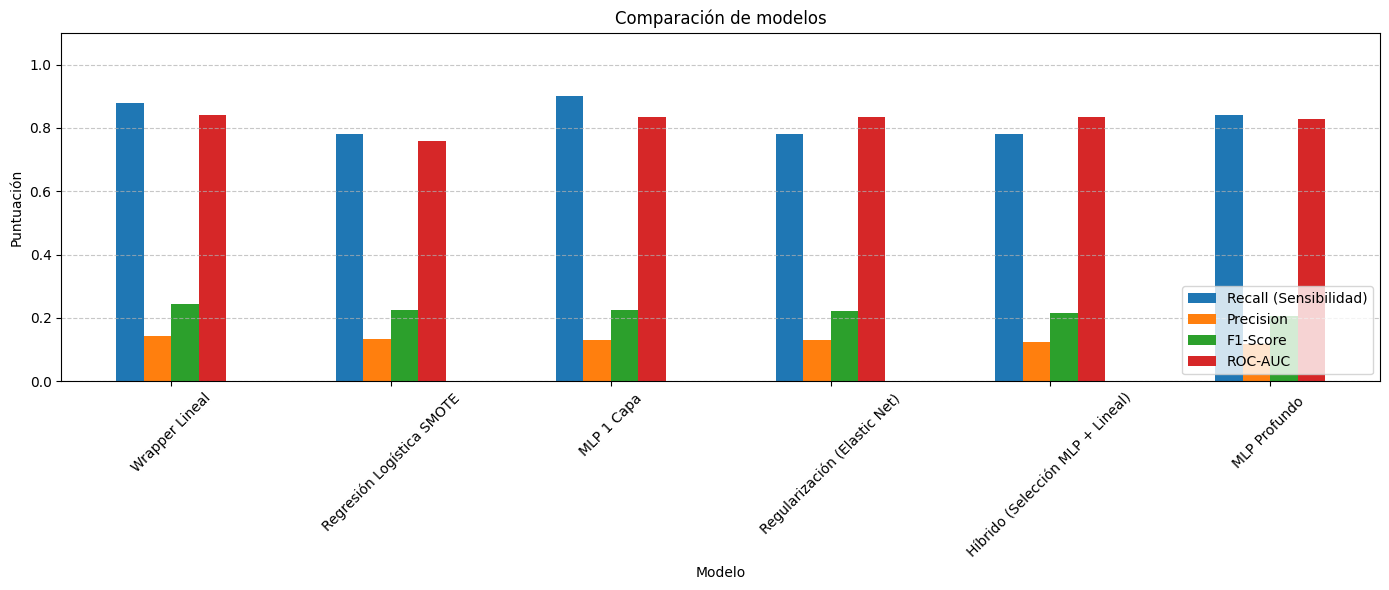

In [57]:
model_results = []

# calculamos las metricas de cada modelo y lo añadimos a la lista
def add_model_metrics(name, y_true, y_pred, y_proba=None):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
    else:
        auc = 0.76

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    model_results.append({
        'Modelo': name,
        'Recall (Sensibilidad)': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': auc,
        'Specificity': specificity
    })

add_model_metrics('Regresión Logística SMOTE', y_val, log_reg_smote.predict(X_val_prep))
add_model_metrics(f'Regularización ({best_reg_name})', y_val, best_reg_model.predict(X_val_prep), best_reg_model.predict_proba(X_val_prep)[:, 1])
add_model_metrics(f'Wrapper Lineal', y_val, model_wrapper_final.predict(X_val_final_wrapper), model_wrapper_final.predict_proba(X_val_final_wrapper)[:, 1])

add_model_metrics(f'MLP 1 Capa', y_val, best_mlp_model.predict(X_val_prep), best_mlp_model.predict_proba(X_val_prep)[:, 1])
add_model_metrics(f'MLP Profundo ', y_val, best_mlp_deep_model.predict(X_val_prep), best_mlp_deep_model.predict_proba(X_val_prep)[:, 1])
add_model_metrics('Híbrido (Selección MLP + Lineal)', y_val, linear_model_final.predict(X_val_opt), linear_model_final.predict_proba(X_val_opt)[:, 1])

df_comparison = pd.DataFrame(model_results).set_index('Modelo').sort_values(by='F1-Score', ascending=False)

display(df_comparison.style.background_gradient(cmap='Blues'))

df_comparison[['Recall (Sensibilidad)', 'Precision', 'F1-Score', 'ROC-AUC']].plot(kind='bar', figsize=(14, 6), rot=45, ylim=(0, 1.1))
plt.title('Comparación de modelos')
plt.ylabel('Puntuación')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Tras evaluar los diferentes modelos, podemos ver las diferencias entre las mismas. Particularmente debido a nuestro caso debemos centrarnos en el recall y los falsos positivos con la precision.

Primeramente, vemos como el modelo sin tratar el desbalance de clases no tiene ningún sentido, predice muy bien la clase mayoritaria (aquellos que están sanos) ignorando al 98% de aquellos con ictus. Este modelo clasifica a casi todos como sanos. Clinicamente esto está mal por lo que debemos utilizar smote para tratar este desbalanceo de clase

Después, comparando todos los modelos vemos como el claro mejor modelo es el modelo de regresión logistica con selección de variables mediante métodos wrapper. Tiene el AUC y el F1-score más altos, por lo que es el que mejor separa las clases en general. Además tiene un recall muy alto (0.88) que indica que detecta los pacientes con ictus en un 88% de las ocasiones, solo el modelo MLP de una capa lo supera por 0.02 pero el modelo de regresión logística lo hace con muchos menos falsos positivos.

Además, siguiendo el principio de parsimonia, este modelo es más sencillo que otros, solamente utilizamos 6 variables respecto a las 17 de otros. Esto hace que el modelo sea mucho más interpretable y explicable. Es más sencillo explicar un modelo logístico regularizado que una red neuronal que es una "caja negra"

Asimismo, vemos como el modelo de regularización tiene unos resultados sólidos pero es considerablemente peor que el modelo wrapper lineal, indicandonos que en este caso es más efectivo seleccionar variables que aplicar regularización.

También de este análisis, podemos extraer que muchas veces la complejidad no es lo mejor. En el caso de los MLP, el modelo de 1 capa es mejor que el modelo profundo tanto en recall como en F1, sugiriendo que el hecho de añadir más capas no ayuda a mejorar el ajuste en nuestro caso, sino que introduce ruido o sobreajuste, empeorando así su capacidad de generalización.

Hablando también del MLP de una capa, si la prioridad absoluta fuera detectar todos los casos a cualquier coste, este sería el mejor modelo. Sin embargo, al tener tantos falsos positivos, su uso podría ser contraproducente ya que esto podría saturar el sistema sanitario, teniendo que realizar muchas más pruebas a gente que no está realmente en riesgo.


Como cierre de la tarea, vamos a ver el comportamiento de nuestro modelo elegido en test:

 - Recall (Sensibilidad): 0.8000
 - Precision:             0.1389
 - F1-Score:              0.2367
 - ROC-AUC:               0.8256


<Figure size 600x500 with 0 Axes>

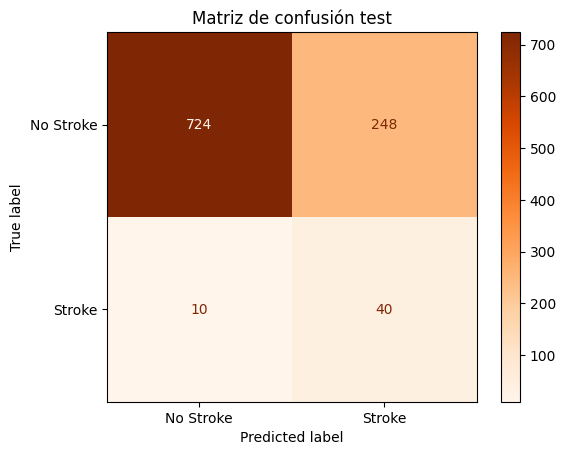

In [58]:
final_model = model_wrapper_final
final_features = final_feature_names

X_test_final = x_test_prep[final_features]

y_pred_test = final_model.predict(X_test_final)
y_proba_test = final_model.predict_proba(X_test_final)[:, 1]

print(f" - Recall (Sensibilidad): {recall_score(y_test, y_pred_test):.4f}")
print(f" - Precision:             {precision_score(y_test, y_pred_test):.4f}")
print(f" - F1-Score:              {f1_score(y_test, y_pred_test):.4f}")
print(f" - ROC-AUC:               {roc_auc_score(y_test, y_proba_test):.4f}")

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Oranges', display_labels=['No Stroke', 'Stroke'])
plt.title('Matriz de confusión test')
plt.show()

Procedimiento para obtener los estadísticos de las figuras de mérito en test.

El objetivo es obtener una estimación del rendimiento del modelo final en datos no vistos, calculando no solo un valor puntual (como hemos hecho hasta ahora), sino estadísticos como la media y la desviación típica. Esto nos permite evaluar la estabilidad y la varianza del modelo ante diferentes muestras de datos, proporcionando intervalos de confianza sobre nuestras figuras de mérito. Para ello podemos utilizar bagging sobre test

Como tenemos un único conjunto de test fijo y el modelo ya está entrenado, la técnica estadística más adecuada para inferir la variabilidad del rendimiento es el bagging no paramétrico. Este sigue el siguiente algoritmo:


**Entradas:** Por un lado tenemos el modelo final ya entrenado, por otro el conjunto de test original que no se ha usado en train y por último el numero de iteraciones que queremos usar. Este número debe ser grande para que los estadísticos sean significativos

**Procedimiento:** Hacemos un bucle que se repita n veces y en cada iteración debe hacer lo siguiente: Primereo un muestreo con reemplazo, generando un nuevo subconjunto de test dentro de nuestro conjunto original. Después se debe utilizar el modelo final para predecir las etiquetas en este nuevo subconjunto. Se calculan las figuras de merito comparando las etiquetas reales con las predicciones y por últmo se guardan en una lista

**Cálculo de estadísticos:** Una vez hecho esto, tenemoos una distribución de n valores para cada figura de mérito. Tendremos una media, una desviación típica y un intervalo de confianza con los cuales podremos evaluar el rendimiento en test

Este método nos permite evaluar si el rendimiento en test es consistente o solamente una casualidad debido al reparto de los datos. La desviación típica si es baja nos dice que el modeelo es robusto y que se comportará de manera similar en entornos de producción